In [1]:
# ============================================
# 공통 설정: 라이브러리, 스타일, 데이터 준비
# ============================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.inspection import permutation_importance, PartialDependenceDisplay

from statsmodels.graphics.mosaicplot import mosaic
import matplotlib.font_manager as fm
import squarify

# -------------------------------------------------------------------
# 0-1. 시각화 스타일 통합
# -------------------------------------------------------------------
sns.set_theme(style="whitegrid", context="talk")  # 보고서용 깨끗한 스타일
plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["axes.titlesize"] = 16
plt.rcParams["axes.labelsize"] = 13

# 한글 폰트 설정 (노트북 전체에 한 번만)
font_list = [font.name for font in fm.fontManager.ttflist]
korean_fonts = ['Malgun Gothic', 'NanumGothic', 'NanumBarunGothic', 'AppleGothic', 'Gulim']
selected_font = None
for f in korean_fonts:
    if f in font_list:
        selected_font = f
        break

if selected_font:
    plt.rcParams['font.family'] = selected_font
    plt.rcParams['axes.unicode_minus'] = False

# 섹션 타이틀 출력용 함수
def print_section(title_ko, title_en=None):
    print("\n" + "=" * 70)
    print(f"{title_ko}")
    if title_en:
        print(f"({title_en})")
    print("=" * 70 + "\n")

# 데이터 준비 헬퍼 함수 (전역 변수로 사용 가능)
def ensure_df_scaled():
    """df_scaled가 준비되어 있는지 확인하고, 없으면 생성"""
    global df_scaled, feature_cols
    
    if 'df_scaled' in globals() and df_scaled is not None:
        # diagnosis가 숫자인지 확인
        if df_scaled['diagnosis'].dtype == 'object':
            df_scaled['diagnosis'] = df_scaled['diagnosis'].map({'M': 1, 'B': 0, '악성(M)': 1, '양성(B)': 0})
            df_scaled['diagnosis'] = pd.to_numeric(df_scaled['diagnosis'], errors='coerce')
            df_scaled = df_scaled.dropna(subset=['diagnosis'])
        return df_scaled
    
    # df_scaled가 없으면 생성
    print("⚠️ df_scaled를 생성합니다...")
    
    # 데이터 소스 선택
    if 'df_clean' in globals():
        df_temp = df_clean.copy()
    elif 'df_encoded' in globals():
        df_temp = df_encoded.copy()
    elif 'df' in globals():
        df_temp = df.copy()
        # diagnosis 인코딩
        if df_temp['diagnosis'].dtype == 'object':
            df_temp['diagnosis'] = df_temp['diagnosis'].map({'M': 1, 'B': 0})
    else:
        raise ValueError("df, df_encoded, 또는 df_clean이 필요합니다.")
    
    # feature_cols 정의
    if 'feature_cols' not in globals() or feature_cols is None:
        feature_cols = [col for col in df_temp.columns if col not in ['id', 'diagnosis', 'Unnamed: 32']]
    
    # 정규화
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df_temp[feature_cols])
    df_scaled = pd.DataFrame(X_scaled, columns=feature_cols)
    df_scaled['diagnosis'] = pd.to_numeric(df_temp['diagnosis'], errors='coerce')
    
    # NaN 제거
    df_scaled = df_scaled.dropna(subset=['diagnosis'])
    
    print("✅ df_scaled 생성 완료")
    return df_scaled

# -------------------------------------------------------------------
# 0-2. 데이터 로드 & 전처리
# -------------------------------------------------------------------
data_path = "data.csv"   # 파일 경로 맞게 조정
df = pd.read_csv(data_path)

print_section("데이터 기본 정보 요약", "Basic Data Summary")
print(f"데이터 shape: {df.shape}")
print(f"컬럼 수: {len(df.columns)}")
print("\n진단 분포 (0=Benign, 1=Malignant):")
print(df['diagnosis'].value_counts())
print("\n결측치 개수:", df.isnull().sum().sum())

# 특징 / 타깃 분리
target_col = 'diagnosis'
# id, diagnosis, Unnamed: 32 제외
feature_cols = [c for c in df.columns if c not in [target_col, 'id', 'Unnamed: 32']]

# diagnosis 인코딩 (M=1, B=0) - 문자열이면 숫자로 변환
if df[target_col].dtype == 'object':
    y = df[target_col].map({'M': 1, 'B': 0})
else:
    y = df[target_col]

X_raw = df[feature_cols]

# 스케일링
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_raw)
df_scaled = pd.DataFrame(X_scaled, columns=feature_cols)
df_scaled[target_col] = y.values

# diagnosis가 숫자인지 확인
if df_scaled[target_col].dtype == 'object':
    df_scaled[target_col] = pd.to_numeric(df_scaled[target_col], errors='coerce')

# 학습/테스트 분할
X_train, X_test, y_train, y_test = train_test_split(
    df_scaled[feature_cols],
    df_scaled[target_col],
    test_size=0.2,
    random_state=42,
    stratify=df_scaled[target_col]
)

# 모델 학습 (RandomForest + DecisionTree)
rf_clf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)
rf_clf.fit(X_train, y_train)

dt_clf = DecisionTreeClassifier(
    max_depth=4,
    random_state=42
)
dt_clf.fit(X_train, y_train)

print("✅ 데이터 전처리 및 기본 모델 학습 완료")



데이터 기본 정보 요약
(Basic Data Summary)

데이터 shape: (569, 33)
컬럼 수: 33

진단 분포 (0=Benign, 1=Malignant):
diagnosis
B    357
M    212
Name: count, dtype: int64

결측치 개수: 569
✅ 데이터 전처리 및 기본 모델 학습 완료


In [2]:
# 데이터 로드
data_path = "data.csv"
df = pd.read_csv(data_path)

print(f"데이터 shape: {df.shape}")
print(f"\n컬럼 목록:\n{df.columns.tolist()}")
print(f"\n결측치 확인:\n{df.isnull().sum().sum()}개")
print(f"\n데이터 타입:\n{df.dtypes}")
print(f"\n진단 분포:\n{df['diagnosis'].value_counts()}")

df.head()


데이터 shape: (569, 33)

컬럼 목록:
['id', 'diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean', 'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean', 'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se', 'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se', 'fractal_dimension_se', 'radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst', 'smoothness_worst', 'compactness_worst', 'concavity_worst', 'concave points_worst', 'symmetry_worst', 'fractal_dimension_worst', 'Unnamed: 32']

결측치 확인:
569개

데이터 타입:
id                           int64
diagnosis                   object
radius_mean                float64
texture_mean               float64
perimeter_mean             float64
area_mean                  float64
smoothness_mean            float64
compactness_mean           float64
concavity_mean             float64
concave points_mean        float64
symmetry_mean     

id diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0    842302         M        17.99         10.38          122.80     1001.0   
1    842517         M        20.57         17.77          132.90     1326.0   
2  84300903         M        19.69         21.25          130.00     1203.0   
3  84348301         M        11.42         20.38           77.58      386.1   
4  84358402         M        20.29         14.34          135.10     1297.0   

   smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
0          0.11840           0.27760          0.3001              0.14710   
1          0.08474           0.07864          0.0869              0.07017   
2          0.10960           0.15990          0.1974              0.12790   
3          0.14250           0.28390          0.2414              0.10520   
4          0.10030           0.13280          0.1980              0.10430   

   ...  texture_worst  perimeter_worst  area_worst  smoothness_worst  \
0  ...          17.33           184.60      2019.0            0.1622   
1  ...          23.41           158.80      1956.0            0.1238   
2  ...          25.53           152.50      1709.0            0.1444   
3  ...          26.50            98.87       567.7            0.2098   
4  ...          16.67           152.20      1575.0            0.1374   

   compactness_worst  concavity_worst  concave points_worst  symmetry_worst  \
0             0.6656           0.7119                0.2654          0.4601   
1             0.1866           0.2416                0.1860          0.2750   
2             0.4245           0.4504                0.2430          0.3613   
3             0.8663           0.6869                0.2575          0.6638   
4             0.2050           0.4000                0.1625          0.2364   

   fractal_dimension_worst  Unnamed: 32  
0                  0.11890          NaN  
1                  0.08902          NaN  
2                  0.08758          NaN  
3                  0.17300          NaN  
4                  0.07678          NaN  

[5 rows x 33 columns]


시각화: 초기 Boxplot (이상치 탐색)
(Initial Feature Boxplots)



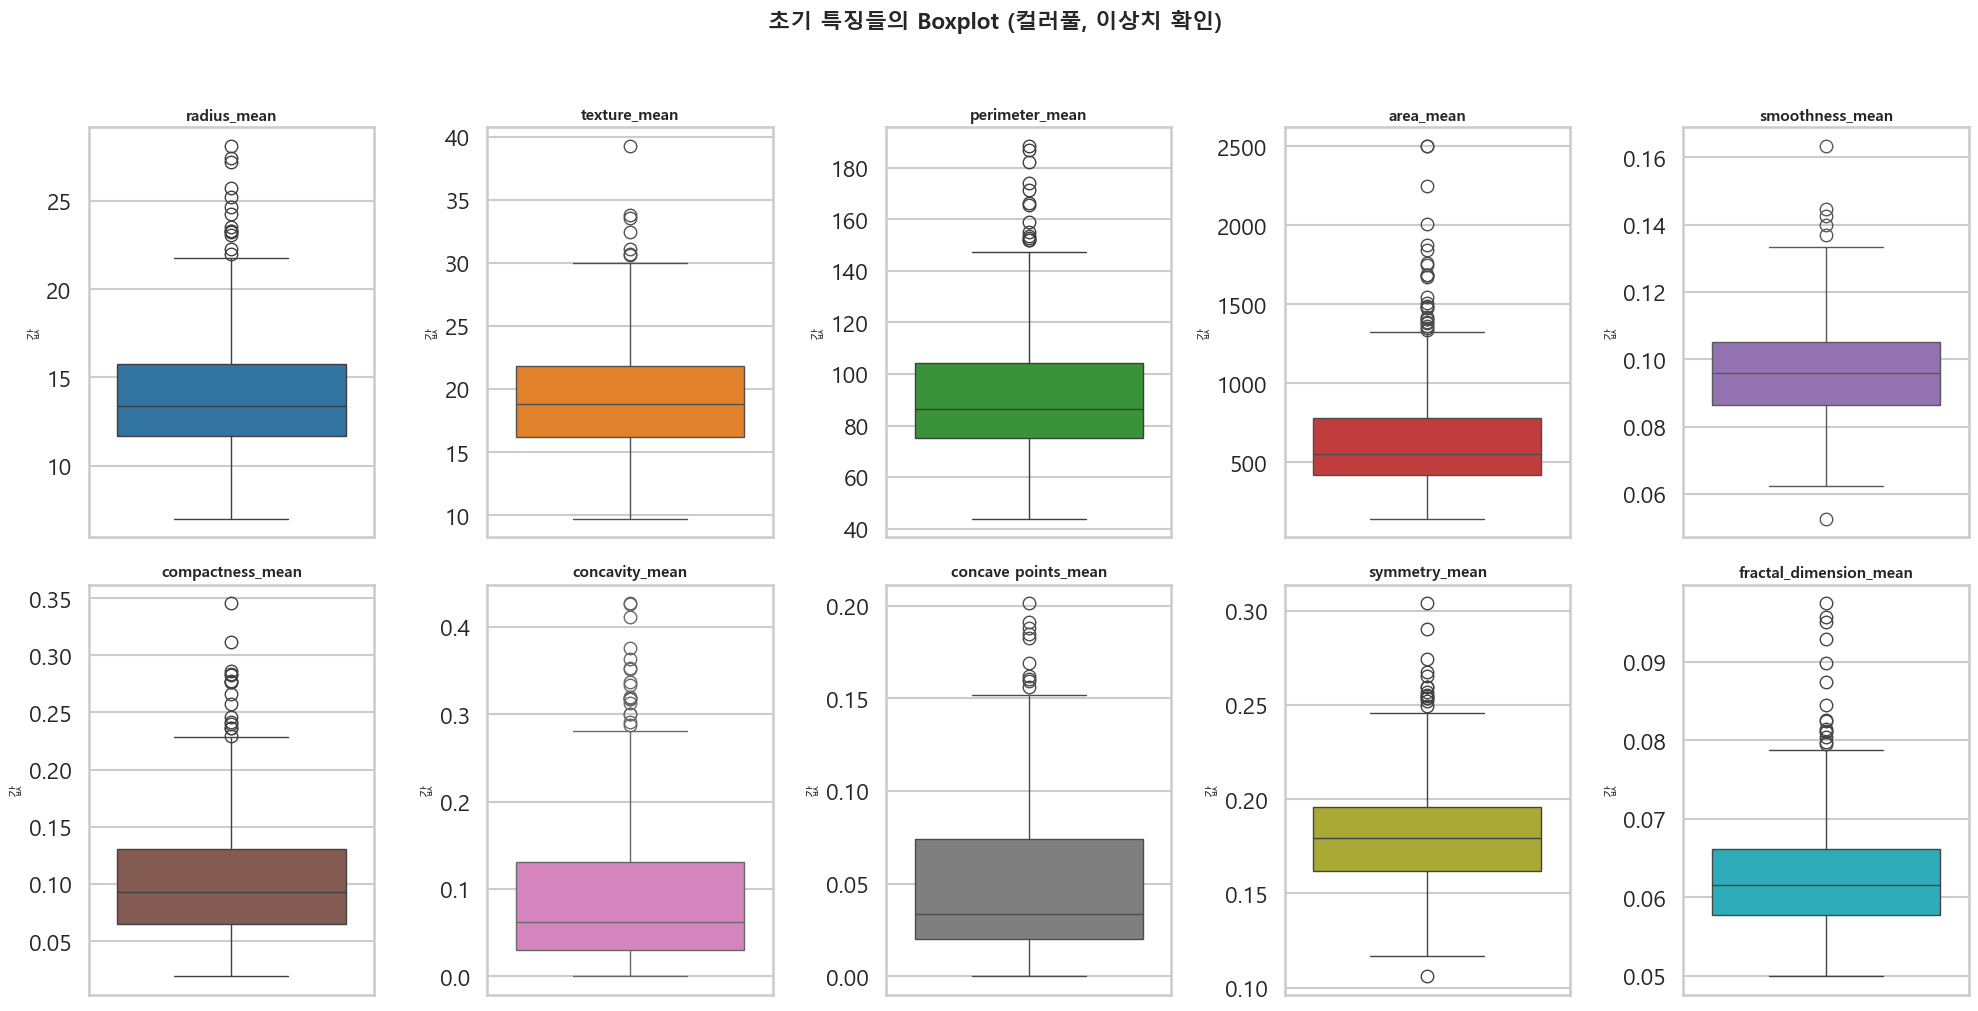

Boxplot 분석: 각 특징별 분포 차이 및 이상치 존재 확인됨


In [3]:
# ============================================
# 초기 Boxplot으로 이상치 확인 (컬러풀 버전)
# ============================================

print_section("시각화: 초기 Boxplot (이상치 탐색)", "Initial Feature Boxplots")

# Boxplot 대상 특징 (예: 처음 10개)
features = df.columns[2:12]
num_features = len(features)

# 컬러 팔레트 생성 (Seaborn color palette)
colors = sns.color_palette("tab10", num_features)  # 10개 색 자동 생성

fig, axes = plt.subplots(2, 5, figsize=(20, 10))
axes = axes.flatten()  # 1D 배열 변환

for i, (ax, feature) in enumerate(zip(axes, features)):
    sns.boxplot(
        y=df[feature],
        ax=ax,
        color=colors[i],   # <-- 핵심: 컬러 개별 적용
        orient="v"
    )
    ax.set_title(feature, fontsize=11, fontweight='bold')
    ax.set_xlabel("")
    ax.set_ylabel("값", fontsize=9)

# 빈 subplot 제거
for ax in axes[num_features:]:
    ax.remove()

plt.suptitle("초기 특징들의 Boxplot (컬러풀, 이상치 확인)", fontsize=16, y=1.02, fontweight='bold')
plt.tight_layout()
plt.show()

print("Boxplot 분석: 각 특징별 분포 차이 및 이상치 존재 확인됨")


In [4]:
# ============================================
# 1단계: 데이터 인코딩 (M=1, B=0)
# ============================================
print("=" * 50)
print("1단계: 진단 라벨 인코딩")
print("=" * 50)

df_encoded = df.copy()
# M(악성) = 1, B(양성) = 0으로 인코딩
df_encoded['diagnosis'] = df_encoded['diagnosis'].map({'M': 1, 'B': 0})

print(f"인코딩 후 진단 분포:")
print(df_encoded['diagnosis'].value_counts().sort_index())
print(f"\n인코딩 확인: M -> {df_encoded[df['diagnosis']=='M']['diagnosis'].iloc[0]}, B -> {df_encoded[df['diagnosis']=='B']['diagnosis'].iloc[0]}")

# 특징 컬럼 선택 (id와 diagnosis 제외)
feature_cols = [col for col in df_encoded.columns if col not in ['id', 'diagnosis']]
print(f"\n특징 개수: {len(feature_cols)}개")

df_encoded.head()


1단계: 진단 라벨 인코딩
인코딩 후 진단 분포:
diagnosis
0    357
1    212
Name: count, dtype: int64

인코딩 확인: M -> 1, B -> 0

특징 개수: 31개


id  diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0    842302          1        17.99         10.38          122.80     1001.0   
1    842517          1        20.57         17.77          132.90     1326.0   
2  84300903          1        19.69         21.25          130.00     1203.0   
3  84348301          1        11.42         20.38           77.58      386.1   
4  84358402          1        20.29         14.34          135.10     1297.0   

   smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
0          0.11840           0.27760          0.3001              0.14710   
1          0.08474           0.07864          0.0869              0.07017   
2          0.10960           0.15990          0.1974              0.12790   
3          0.14250           0.28390          0.2414              0.10520   
4          0.10030           0.13280          0.1980              0.10430   

   ...  texture_worst  perimeter_worst  area_worst  smoothness_worst  \
0  ...          17.33           184.60      2019.0            0.1622   
1  ...          23.41           158.80      1956.0            0.1238   
2  ...          25.53           152.50      1709.0            0.1444   
3  ...          26.50            98.87       567.7            0.2098   
4  ...          16.67           152.20      1575.0            0.1374   

   compactness_worst  concavity_worst  concave points_worst  symmetry_worst  \
0             0.6656           0.7119                0.2654          0.4601   
1             0.1866           0.2416                0.1860          0.2750   
2             0.4245           0.4504                0.2430          0.3613   
3             0.8663           0.6869                0.2575          0.6638   
4             0.2050           0.4000                0.1625          0.2364   

   fractal_dimension_worst  Unnamed: 32  
0                  0.11890          NaN  
1                  0.08902          NaN  
2                  0.08758          NaN  
3                  0.17300          NaN  
4                  0.07678          NaN  

[5 rows x 33 columns]

2단계: 이상치 처리 (IQR 방법)
df_encoded 사용
이상치가 있는 행 수: 171개
원본 데이터: 569행
⚠️ 이상치 비율이 높아 제거 대신 클리핑을 사용합니다.
클리핑 완료: 이상치를 경계값으로 제한했습니다.


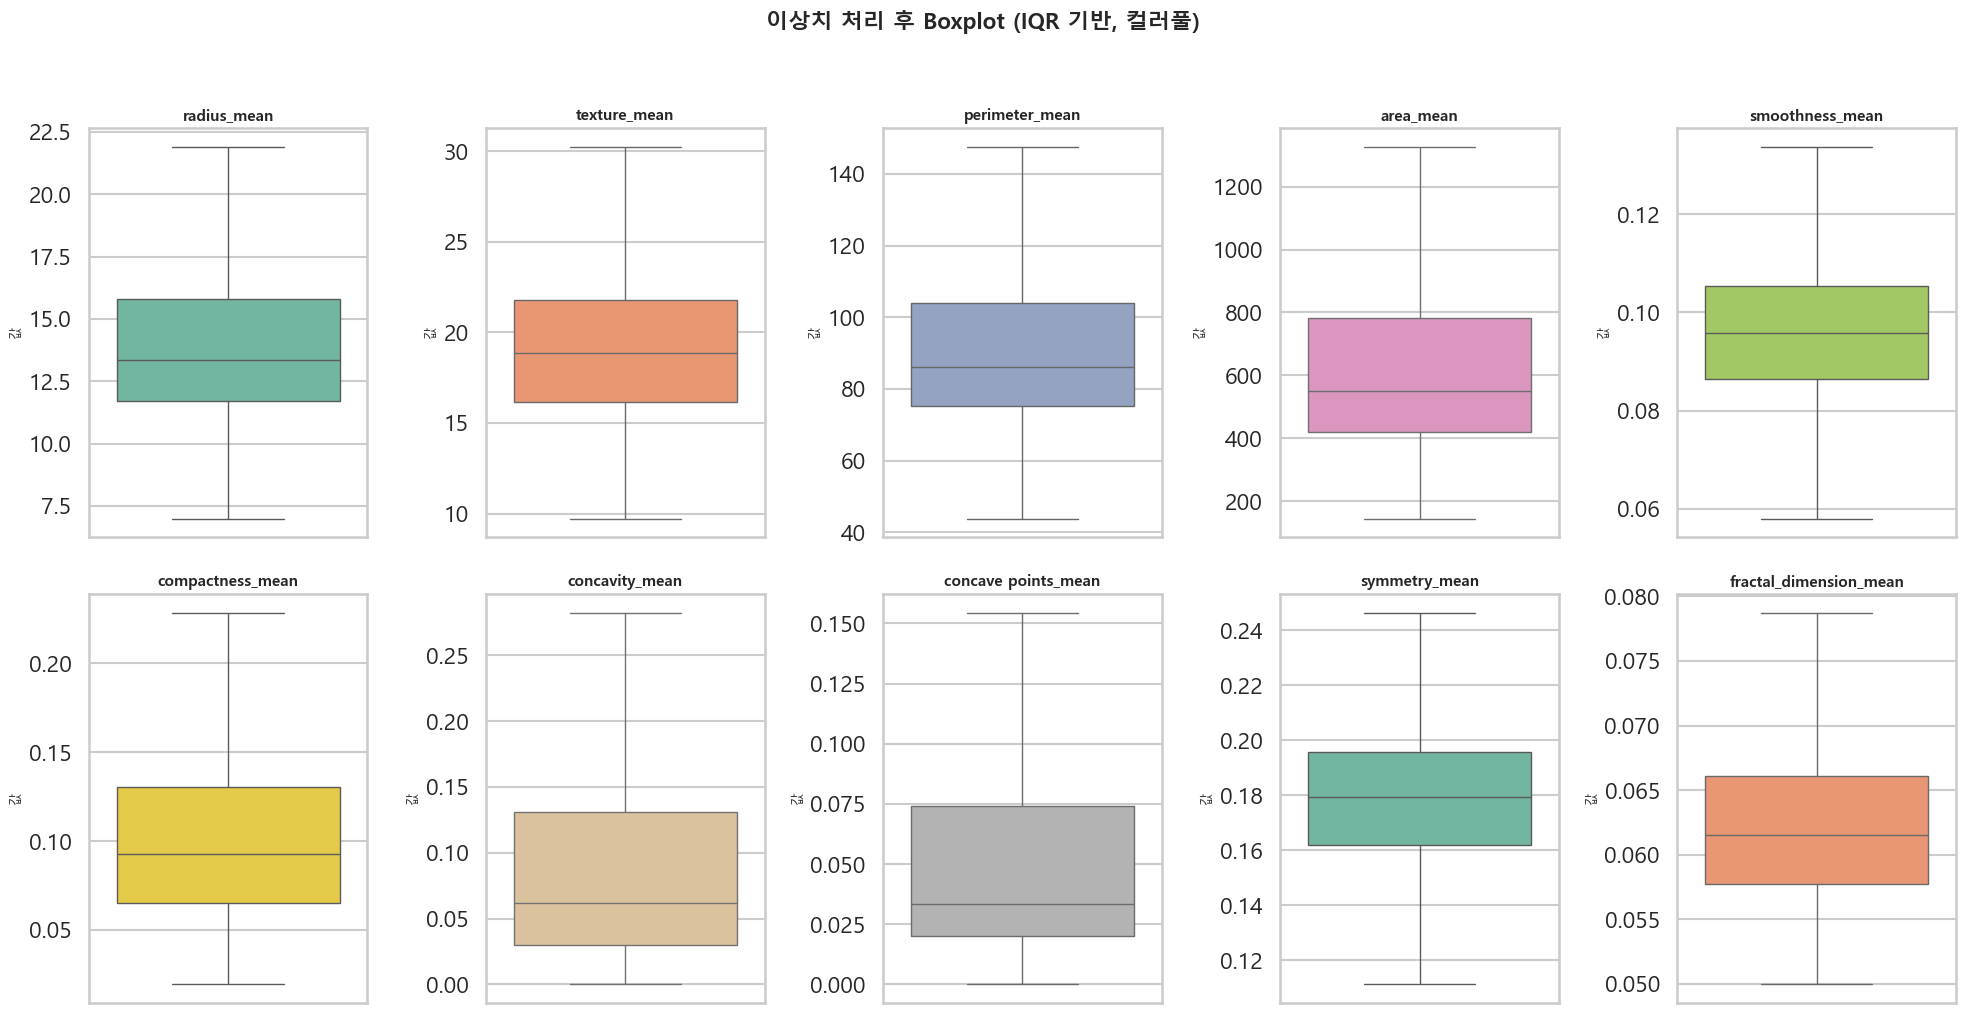

이상치 처리 후 Boxplot: 각 특징별 분포 변화와 이상치 감소 여부를 시각적으로 확인할 수 있음.


In [5]:
# ============================================
# 2단계: 이상치 처리 (IQR 방법)
# ============================================
print("=" * 50)
print("2단계: 이상치 처리 (IQR 방법)")
print("=" * 50)

# 한글 폰트 재확인 및 적용
import matplotlib.font_manager as fm
font_list = [font.name for font in fm.fontManager.ttflist]
korean_fonts = ['Malgun Gothic', 'NanumGothic', 'NanumBarunGothic', 'AppleGothic', 'Gulim']
selected_font = None
for font in korean_fonts:
    if font in font_list:
        selected_font = font
        break

if selected_font:
    plt.rcParams['font.family'] = selected_font
    plt.rcParams['axes.unicode_minus'] = False

# df_encoded가 있으면 사용, 없으면 df 사용
if 'df_encoded' in globals():
    df_temp = df_encoded.copy()
    print("df_encoded 사용")
else:
    df_temp = df.copy()
    print("df 사용")

# 특징 컬럼 선택 (id와 diagnosis 제외)
feature_cols_clean = [col for col in df_temp.columns if col not in ['id', 'diagnosis', 'Unnamed: 32']]

# IQR 방법으로 이상치 처리
df_clean = df_temp.copy()
outlier_count = 0
outlier_rows = set()

for col in feature_cols_clean:
    if df_clean[col].dtype in [np.int64, np.float64]:
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        outliers = (df_clean[col] < lower_bound) | (df_clean[col] > upper_bound)
        outlier_rows.update(df_clean[outliers].index.tolist())
        outlier_count += outliers.sum()

print(f"이상치가 있는 행 수: {len(outlier_rows)}개")
print(f"원본 데이터: {len(df_clean)}행")

# 이상치 제거 대신 클리핑(경계값으로 제한) 사용 (이상치 비율이 높을 경우)
if len(outlier_rows) > len(df_clean) * 0.3:
    print("⚠️ 이상치 비율이 높아 제거 대신 클리핑을 사용합니다.")
    for col in feature_cols_clean:
        if df_clean[col].dtype in [np.int64, np.float64]:
            Q1 = df_clean[col].quantile(0.25)
            Q3 = df_clean[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            df_clean[col] = df_clean[col].clip(lower_bound, upper_bound)
    print("클리핑 완료: 이상치를 경계값으로 제한했습니다.")
else:
    # 이상치 제거
    df_clean = df_clean.drop(index=outlier_rows)
    print(f"이상치 제거 완료: {len(df_clean)}행 남음")

# ============================================
# 이상치 처리 후 Boxplot (컬러풀 버전)
# ============================================

# features 정의
features = df.columns[2:12].tolist()  # 처음에 썼던 features와 동일하게 유지

# df_clean에 존재하는 features만 사용
available_features = [f for f in features if f in df_clean.columns]

if len(available_features) == 0:
    print("⚠️ 사용 가능한 특징이 없습니다. 원본 df 사용")
    df_clean = df.copy()
    available_features = features

num_features = len(available_features)
colors = sns.color_palette("Set2", num_features)  # 논문용으로 무난한 파스텔 계열

fig, axes = plt.subplots(2, 5, figsize=(20, 10))
axes = axes.flatten()

for i, (ax, feature) in enumerate(zip(axes, available_features)):
    if feature in df_clean.columns:
        sns.boxplot(
            y=df_clean[feature],
            ax=ax,
            color=colors[i],   # ← 각 feature마다 다른 색상
            orient="v"
        )
        if selected_font:
            ax.set_title(feature, fontsize=11, fontweight='bold', fontfamily=selected_font)
            ax.set_ylabel("값", fontsize=9, fontfamily=selected_font)
        else:
            ax.set_title(feature, fontsize=11, fontweight='bold')
            ax.set_ylabel("값", fontsize=9)
        ax.set_xlabel("")
    else:
        ax.text(0.5, 0.5, f'{feature}\n(데이터 없음)', 
                ha='center', va='center', transform=ax.transAxes)
        ax.set_title(feature, fontsize=11, fontweight='bold')

# 남는 subplot 제거
for ax in axes[num_features:]:
    ax.remove()

title_text = "이상치 처리 후 Boxplot (IQR 기반, 컬러풀)"
if selected_font:
    plt.suptitle(title_text, fontsize=16, y=1.02, fontweight='bold', fontfamily=selected_font)
else:
    plt.suptitle(title_text, fontsize=16, y=1.02, fontweight='bold')

plt.tight_layout()
plt.show()

print("이상치 처리 후 Boxplot: 각 특징별 분포 변화와 이상치 감소 여부를 시각적으로 확인할 수 있음.")


시각화 1: 상관관계 히트맵


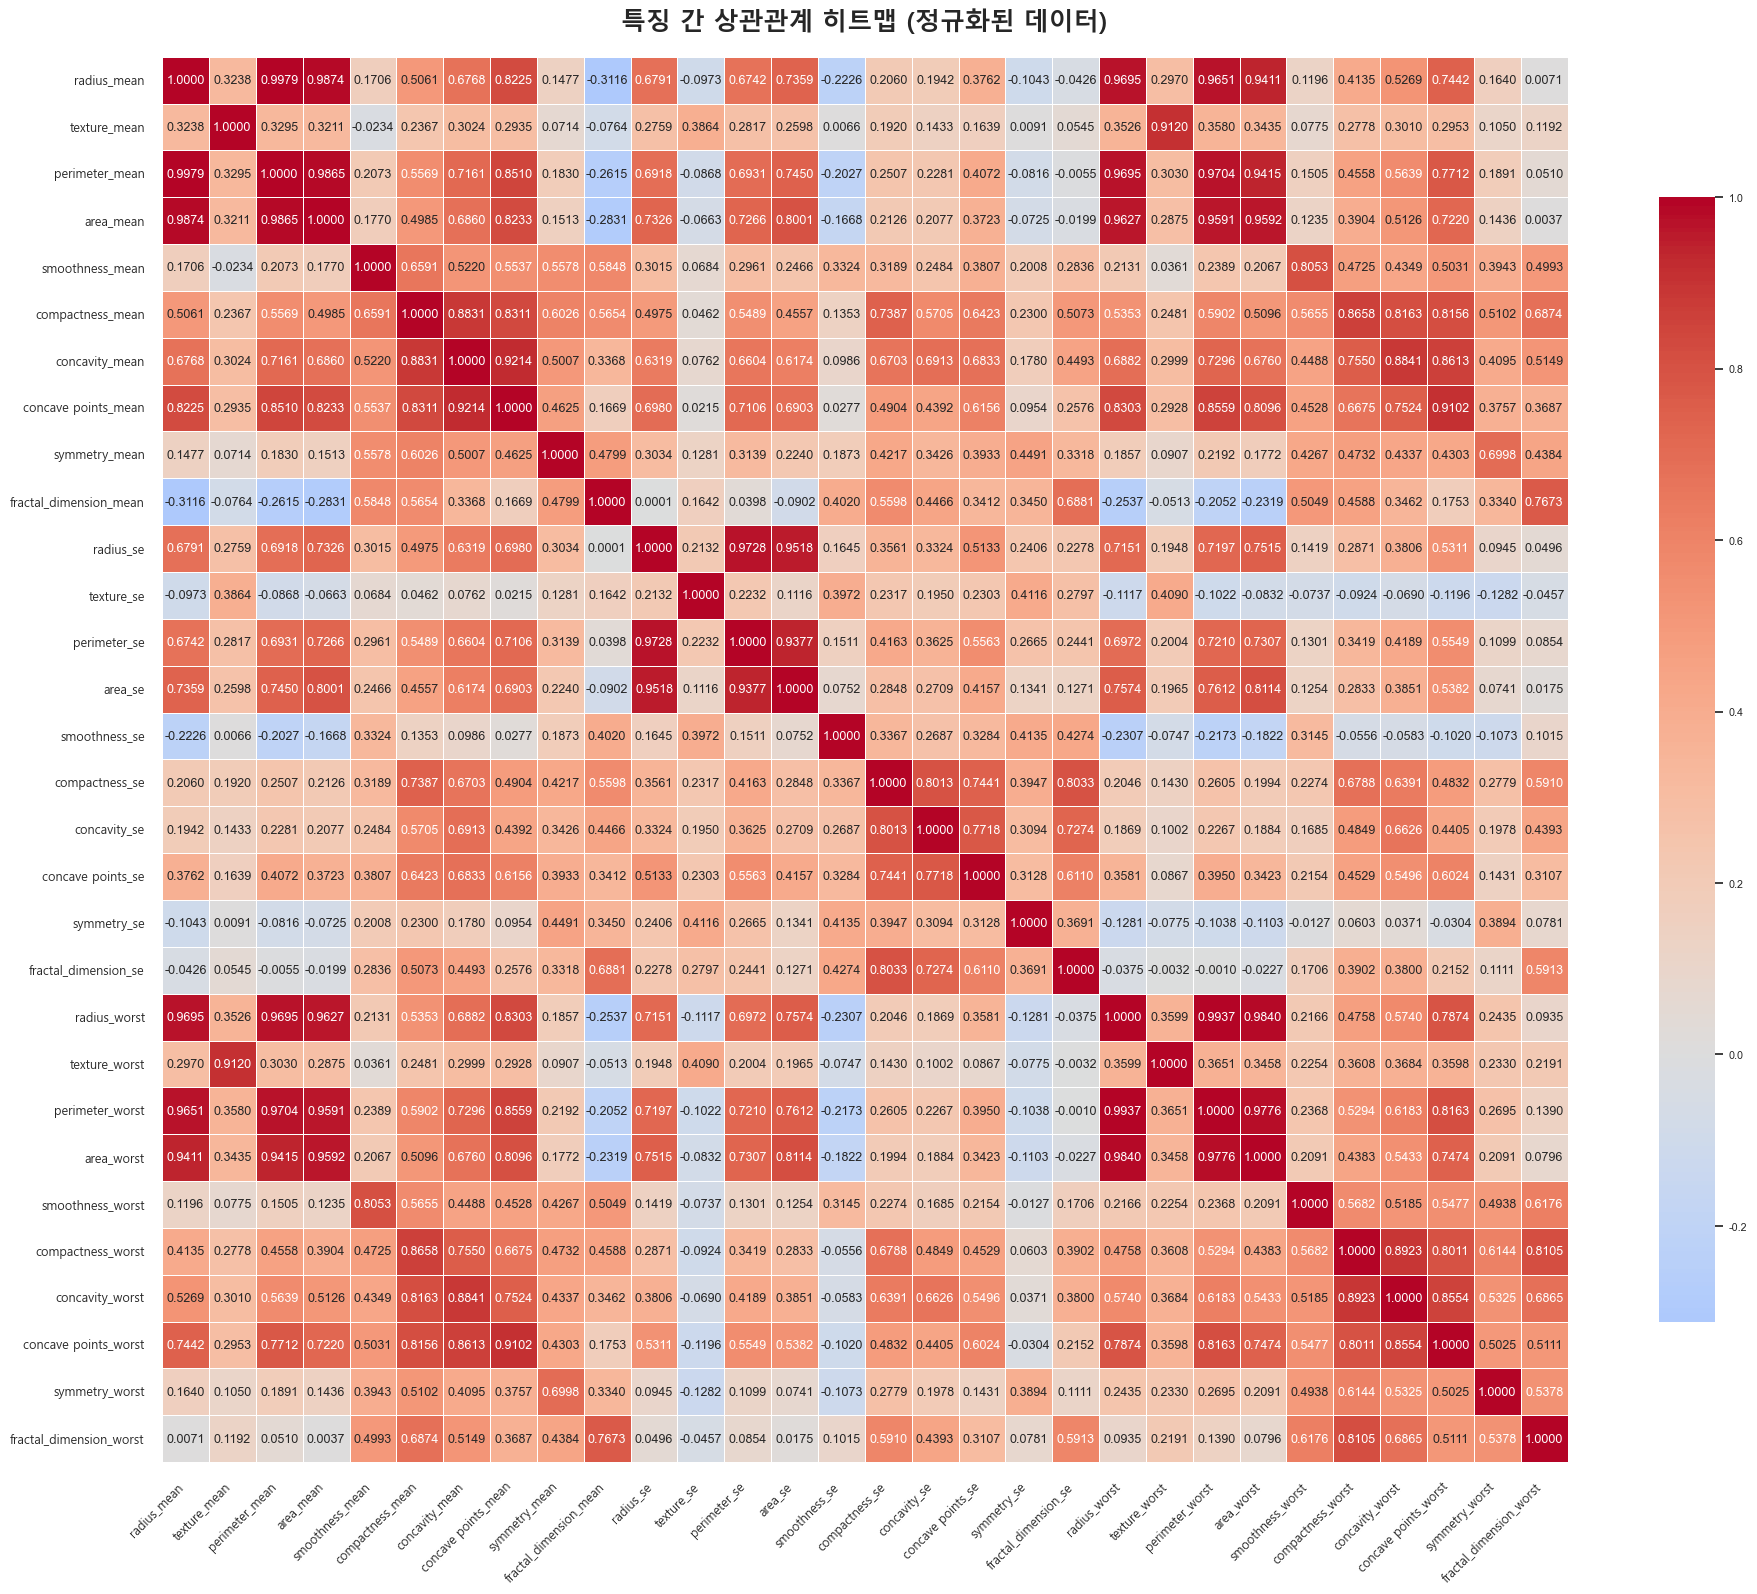

✅ 히트맵 완료: 각 칸에 상관계수가 소수점 4자리까지 표시됩니다.


In [7]:
# ============================================
# 시각화 1: 상관관계 히트맵
# ============================================
print("=" * 50)
print("시각화 1: 상관관계 히트맵")
print("=" * 50)

# df_scaled와 feature_cols 확인
ensure_df_scaled()

# df_scaled에 실제로 존재하는 컬럼만 사용
feature_cols_in_scaled = [c for c in feature_cols if c in df_scaled.columns]

# 상관계수 행렬 계산
corr_matrix = df_scaled[feature_cols_in_scaled].corr()

# 히트맵 생성 (소수점 4자리까지 표시)
fig, ax = plt.subplots(figsize=(20, 16))
sns.set(style="whitegrid", font_scale=0.7)

n_features = len(feature_cols_in_scaled)
font_size = max(6, min(9, 300 // n_features))  # 동적 폰트 크기

heatmap = sns.heatmap(
    corr_matrix,
    cmap='coolwarm',
    center=0,
    linewidths=0.5,
    annot=True,      # 숫자 표시
    fmt='.4f',       # 소수점 4자리까지
    square=True,
    cbar_kws={"shrink": 0.8},
    annot_kws={"size": font_size, "weight": "normal"},
    ax=ax
)

title = '특징 간 상관관계 히트맵 (정규화된 데이터)'
if selected_font:
    ax.set_title(title, fontsize=18, pad=20,
                 fontweight='bold', fontfamily=selected_font)
else:
    ax.set_title(title, fontsize=18, pad=20, fontweight='bold')

ax.set_xlabel('', fontsize=12)
ax.set_ylabel('', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=9)
plt.yticks(rotation=0, fontsize=9)
plt.tight_layout()
plt.show()

print("✅ 히트맵 완료: 각 칸에 상관계수가 소수점 4자리까지 표시됩니다.")


시각화 2: 버블 차트


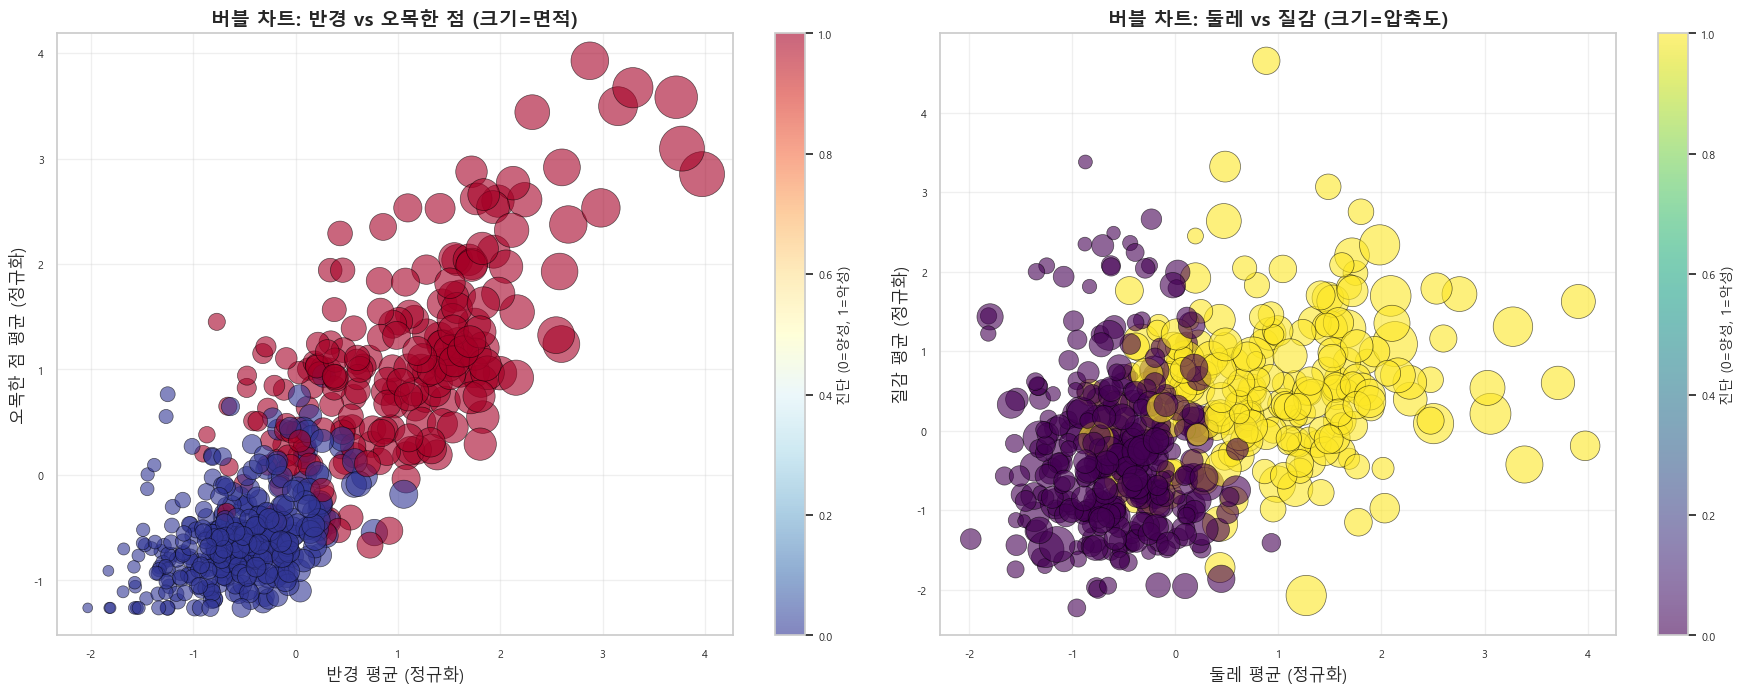

버블 차트 완료: 버블 크기는 세 번째 특징의 값을 나타냄


In [8]:
# ============================================
# 시각화 2: 버블 차트 (Bubble Chart)
# ============================================
print("=" * 50)
print("시각화 2: 버블 차트")
print("=" * 50)

# 한글 폰트 재확인 및 적용
import matplotlib.font_manager as fm
font_list = [font.name for font in fm.fontManager.ttflist]
korean_fonts = ['Malgun Gothic', 'NanumGothic', 'NanumBarunGothic', 'AppleGothic', 'Gulim']
selected_font = None
for font in korean_fonts:
    if font in font_list:
        selected_font = font
        break

if selected_font:
    plt.rcParams['font.family'] = selected_font
    plt.rcParams['axes.unicode_minus'] = False

# 정규화된 데이터 사용
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# 버블 차트 1: radius_mean vs concave points_mean (크기 = area_mean)
bubble_size1 = (df_scaled['area_mean'] - df_scaled['area_mean'].min()) / (
    df_scaled['area_mean'].max() - df_scaled['area_mean'].min()) * 1000 + 50

scatter1 = axes[0].scatter(
    df_scaled['radius_mean'], 
    df_scaled['concave points_mean'],
    s=bubble_size1,
    c=df_scaled['diagnosis'],
    cmap='RdYlBu_r',
    alpha=0.6,
    edgecolors='black',
    linewidth=0.5
)

# 한글 제목 및 라벨 설정
if selected_font:
    axes[0].set_title('버블 차트: 반경 vs 오목한 점 (크기=면적)', 
                     fontsize=14, fontweight='bold', fontfamily=selected_font)
    axes[0].set_xlabel('반경 평균 (정규화)', fontsize=12, fontfamily=selected_font)
    axes[0].set_ylabel('오목한 점 평균 (정규화)', fontsize=12, fontfamily=selected_font)
else:
    axes[0].set_title('버블 차트: 반경 vs 오목한 점 (크기=면적)', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('반경 평균 (정규화)', fontsize=12)
    axes[0].set_ylabel('오목한 점 평균 (정규화)', fontsize=12)

axes[0].grid(True, alpha=0.3)
cbar1 = plt.colorbar(scatter1, ax=axes[0])
if selected_font:
    cbar1.set_label('진단 (0=양성, 1=악성)', fontsize=10, fontfamily=selected_font)
else:
    cbar1.set_label('진단 (0=양성, 1=악성)', fontsize=10)

# 버블 차트 2: perimeter_mean vs texture_mean (크기 = compactness_mean)
bubble_size2 = (df_scaled['compactness_mean'] - df_scaled['compactness_mean'].min()) / (
    df_scaled['compactness_mean'].max() - df_scaled['compactness_mean'].min()) * 1000 + 50

scatter2 = axes[1].scatter(
    df_scaled['perimeter_mean'],
    df_scaled['texture_mean'],
    s=bubble_size2,
    c=df_scaled['diagnosis'],
    cmap='viridis',
    alpha=0.6,
    edgecolors='black',
    linewidth=0.5
)

# 한글 제목 및 라벨 설정
if selected_font:
    axes[1].set_title('버블 차트: 둘레 vs 질감 (크기=압축도)', 
                     fontsize=14, fontweight='bold', fontfamily=selected_font)
    axes[1].set_xlabel('둘레 평균 (정규화)', fontsize=12, fontfamily=selected_font)
    axes[1].set_ylabel('질감 평균 (정규화)', fontsize=12, fontfamily=selected_font)
else:
    axes[1].set_title('버블 차트: 둘레 vs 질감 (크기=압축도)', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('둘레 평균 (정규화)', fontsize=12)
    axes[1].set_ylabel('질감 평균 (정규화)', fontsize=12)

axes[1].grid(True, alpha=0.3)
cbar2 = plt.colorbar(scatter2, ax=axes[1])
if selected_font:
    cbar2.set_label('진단 (0=양성, 1=악성)', fontsize=10, fontfamily=selected_font)
else:
    cbar2.set_label('진단 (0=양성, 1=악성)', fontsize=10)

plt.tight_layout()
plt.show()

print("버블 차트 완료: 버블 크기는 세 번째 특징의 값을 나타냄")


시각화 3: 모자이크 플롯


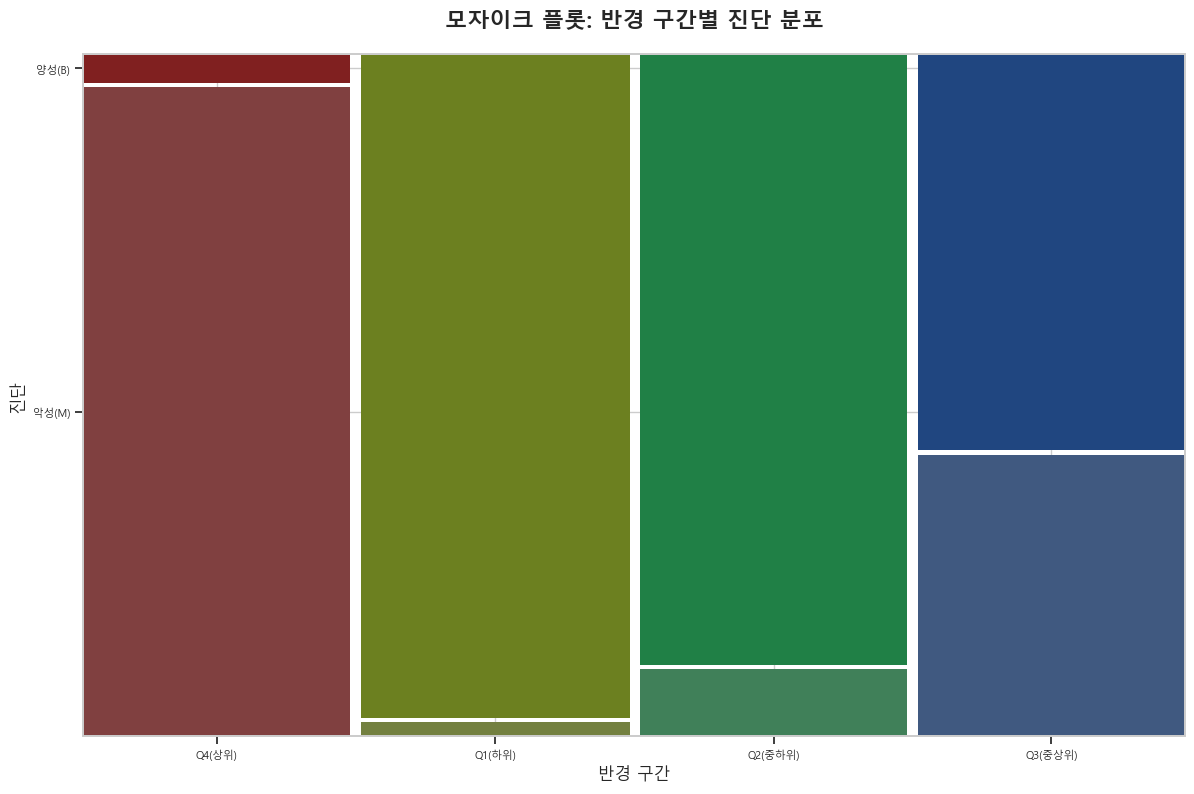


교차표:
diagnosis       악성(M)      양성(B)
radius_bin                      
Q1(하위)       2.097902  97.902098
Q2(중하위)      9.859155  90.140845
Q3(중상위)     41.549296  58.450704
Q4(상위)      95.774648   4.225352


In [9]:
# ============================================
# 시각화 3: 모자이크 플롯 (Mosaic Plot)
# ============================================
print("=" * 50)
print("시각화 3: 모자이크 플롯")
print("=" * 50)

# 한글 폰트 재확인 및 적용
import matplotlib.font_manager as fm
font_list = [font.name for font in fm.fontManager.ttflist]
korean_fonts = ['Malgun Gothic', 'NanumGothic', 'NanumBarunGothic', 'AppleGothic', 'Gulim']
selected_font = None
for font in korean_fonts:
    if font in font_list:
        selected_font = font
        break

if selected_font:
    plt.rcParams['font.family'] = selected_font
    plt.rcParams['axes.unicode_minus'] = False

# radius_mean을 4분위로 나누기
radius_bins = pd.qcut(df_scaled['radius_mean'], q=4, labels=['Q1(하위)', 'Q2(중하위)', 'Q3(중상위)', 'Q4(상위)'])
mosaic_data = pd.DataFrame({
    'radius_bin': radius_bins,
    'diagnosis': df_scaled['diagnosis'].map({0: '양성(B)', 1: '악성(M)'})
})

# 모자이크 플롯 생성
fig, ax = plt.subplots(figsize=(12, 8))
mosaic(mosaic_data, ['radius_bin', 'diagnosis'], ax=ax, title='', 
       labelizer=lambda k: '', gap=0.01)

# 한글 제목 및 라벨 설정
if selected_font:
    ax.set_title('모자이크 플롯: 반경 구간별 진단 분포', 
                fontsize=16, fontweight='bold', pad=20, fontfamily=selected_font)
    ax.set_xlabel('반경 구간', fontsize=12, fontfamily=selected_font)
    ax.set_ylabel('진단', fontsize=12, fontfamily=selected_font)
else:
    ax.set_title('모자이크 플롯: 반경 구간별 진단 분포', fontsize=16, fontweight='bold', pad=20)
    ax.set_xlabel('반경 구간', fontsize=12)
    ax.set_ylabel('진단', fontsize=12)

plt.tight_layout()
plt.show()

# 교차표 출력
print("\n교차표:")
print(pd.crosstab(mosaic_data['radius_bin'], mosaic_data['diagnosis'], normalize='index') * 100)


시각화 4: 레이더 차트


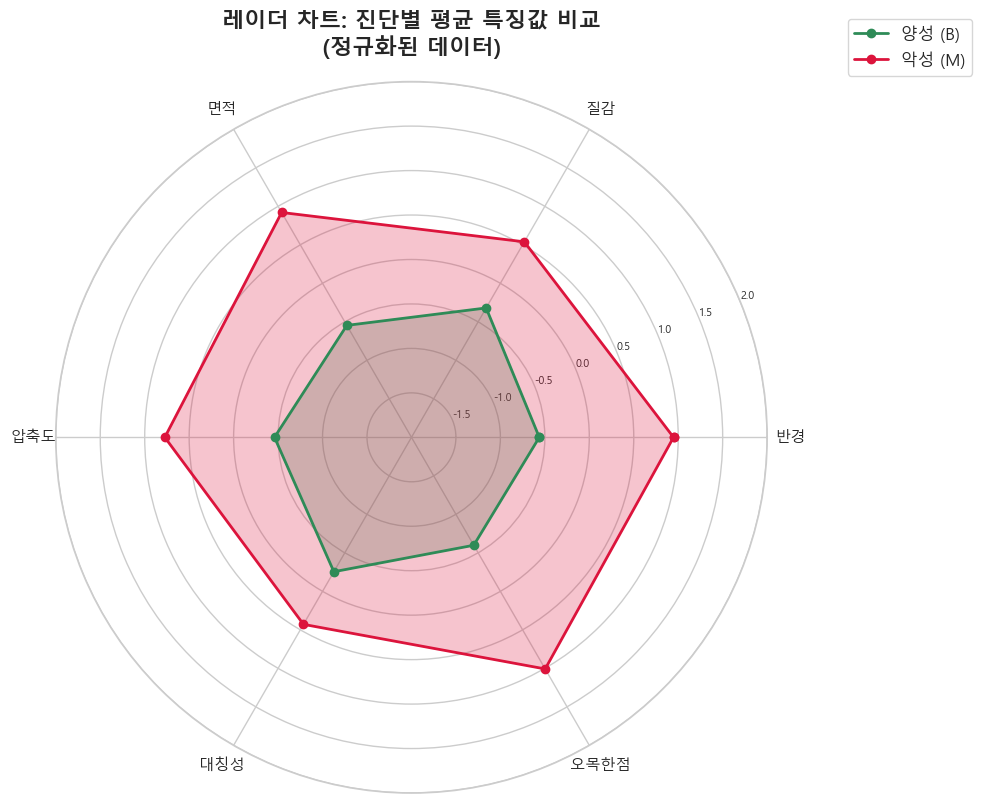

레이더 차트 완료: 양성과 악성의 특징 패턴 비교


In [10]:
# ============================================
# 시각화 4: 레이더 차트 (Radar Chart)
# ============================================
print("=" * 50)
print("시각화 4: 레이더 차트")
print("=" * 50)

# 한글 폰트 재확인 및 적용
import matplotlib.font_manager as fm
font_list = [font.name for font in fm.fontManager.ttflist]
korean_fonts = ['Malgun Gothic', 'NanumGothic', 'NanumBarunGothic', 'AppleGothic', 'Gulim']
selected_font = None
for font in korean_fonts:
    if font in font_list:
        selected_font = font
        break

if selected_font:
    plt.rcParams['font.family'] = selected_font
    plt.rcParams['axes.unicode_minus'] = False

# 주요 특징 선택
radar_features = ['radius_mean', 'texture_mean', 'area_mean', 'compactness_mean', 'symmetry_mean', 'concave points_mean']
radar_data = df_scaled.groupby('diagnosis')[radar_features].mean()

# 각도 계산
angles = np.linspace(0, 2 * np.pi, len(radar_features), endpoint=False)
angles = np.concatenate((angles, [angles[0]]))  # 닫힌 형태를 위해

# 레이더 차트 생성
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='polar')

colors = ['#2E8B57', '#DC143C']
labels_kr = ['반경', '질감', '면적', '압축도', '대칭성', '오목한점']

for idx, (diagnosis_value, row) in enumerate(radar_data.iterrows()):
    values = np.concatenate((row.values, [row.values[0]]))
    label = '악성 (M)' if diagnosis_value == 1 else '양성 (B)'
    ax.plot(angles, values, 'o-', linewidth=2, label=label, color=colors[idx])
    ax.fill(angles, values, alpha=0.25, color=colors[idx])

ax.set_xticks(angles[:-1])
if selected_font:
    ax.set_xticklabels(labels_kr, fontsize=11, fontfamily=selected_font)
else:
    ax.set_xticklabels(labels_kr, fontsize=11)

ax.set_ylim(-2, 2)

# 한글 제목 설정
if selected_font:
    ax.set_title('레이더 차트: 진단별 평균 특징값 비교\n(정규화된 데이터)', 
                 fontsize=16, fontweight='bold', pad=20, fontfamily=selected_font)
else:
    ax.set_title('레이더 차트: 진단별 평균 특징값 비교\n(정규화된 데이터)', 
                 fontsize=16, fontweight='bold', pad=20)

# 범례 설정
legend = ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=12)
if selected_font:
    for text in legend.get_texts():
        text.set_fontfamily(selected_font)

ax.grid(True)

plt.tight_layout()
plt.show()

print("레이더 차트 완료: 양성과 악성의 특징 패턴 비교")


시각화 6: 바이올린 차트
바이올린 플롯에 사용할 특징: ['radius_mean', 'texture_mean', 'compactness_mean', 'symmetry_mean', 'concave points_mean', 'area_mean']


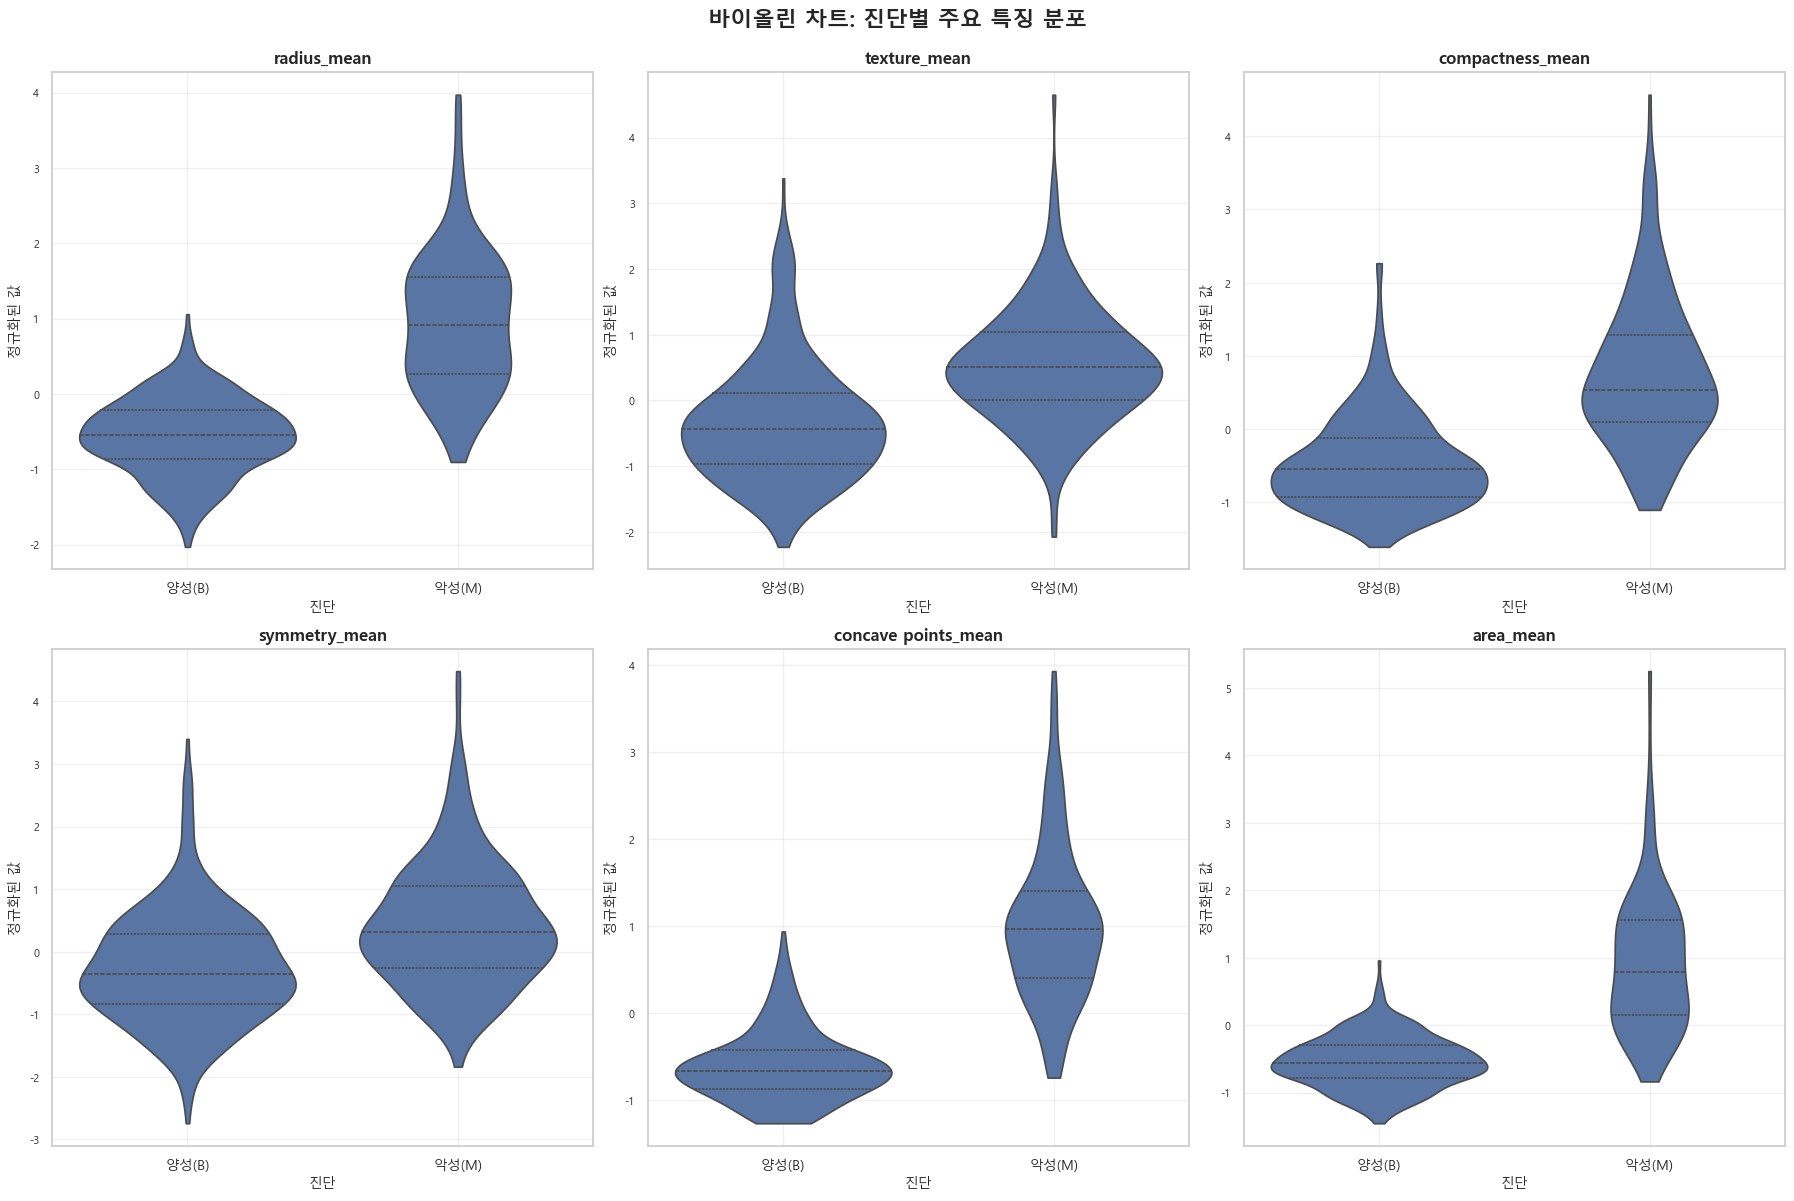

✅ 바이올린 차트 완료: 분포의 형태(폭)와 밀도(두께)를 동시에 확인할 수 있습니다.


In [12]:
# ============================================
# 시각화 6: 바이올린 차트 (Violin Plot)
# ============================================
print("=" * 50)
print("시각화 6: 바이올린 차트")
print("=" * 50)

# df_scaled가 이미 있고, diagnosis / 관심 특징들이 포함되어 있다고 가정
# (위에서 StandardScaler로 만든 df_scaled 사용)

# 주요 특징 선택
violin_features = [
    'radius_mean',
    'texture_mean',
    'compactness_mean',
    'symmetry_mean',
    'concave points_mean',  # 원본 컬럼명이 이게 맞음 (공백 있음)
    'area_mean'
]

# 실제 df_scaled에 존재하는 컬럼만 사용 (오타 방지용)
violin_features = [f for f in violin_features if f in df_scaled.columns]
print("바이올린 플롯에 사용할 특징:", violin_features)

n_features = len(violin_features)
rows, cols = 2, 3

fig, axes = plt.subplots(rows, cols, figsize=(18, 12))

# axes를 1차원 리스트로 펼치기
axes_flat = axes.flatten()

for ax, feature in zip(axes_flat, violin_features):
    sns.violinplot(
        data=df_scaled,
        x='diagnosis',
        y=feature,
        ax=ax,
        inner='quartile',   # 사분위수 표시
        cut=0               # 분포 꼬리 과도하게 그리지 않도록
        # ⚠ palette 인자 제거 → FutureWarning 사라짐
    )
    
    ax.set_title(f'{feature}', fontsize=12, fontweight='bold')
    ax.set_xlabel('진단', fontsize=10)
    ax.set_ylabel('정규화된 값', fontsize=10)
    
    # X축 눈금 위치와 레이블을 같이 지정 → UserWarning 방지
    ticks = ax.get_xticks()  # 보통 [0, 1]
    ax.set_xticks(ticks)
    ax.set_xticklabels(['양성(B)', '악성(M)'], fontsize=10)
    
    ax.grid(True, alpha=0.3)

# 만약 특징 개수가 6개보다 적어서 빈 subplot이 생기면 숨기기
for j in range(len(violin_features), len(axes_flat)):
    axes_flat[j].axis('off')

plt.suptitle('바이올린 차트: 진단별 주요 특징 분포', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

print("✅ 바이올린 차트 완료: 분포의 형태(폭)와 밀도(두께)를 동시에 확인할 수 있습니다.")


시각화 7: PCA (주성분 분석)
PCA 사용 특징 개수: 31
예시 특징: ['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean', 'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean']
y_pca: diagnosis를 B=0, M=1로 매핑해서 사용
PCA 데이터 확인: 569개 샘플, 31개 특징
NaN 값: 0개
무한대 값: 0개

2D PCA 설명 분산:
  주성분 1: 44.41%
  주성분 2: 18.85%
  총 설명 분산: 63.26%

3D PCA 설명 분산:
  주성분 1: 44.41%
  주성분 2: 18.85%
  주성분 3: 9.34%
  총 설명 분산: 72.60%


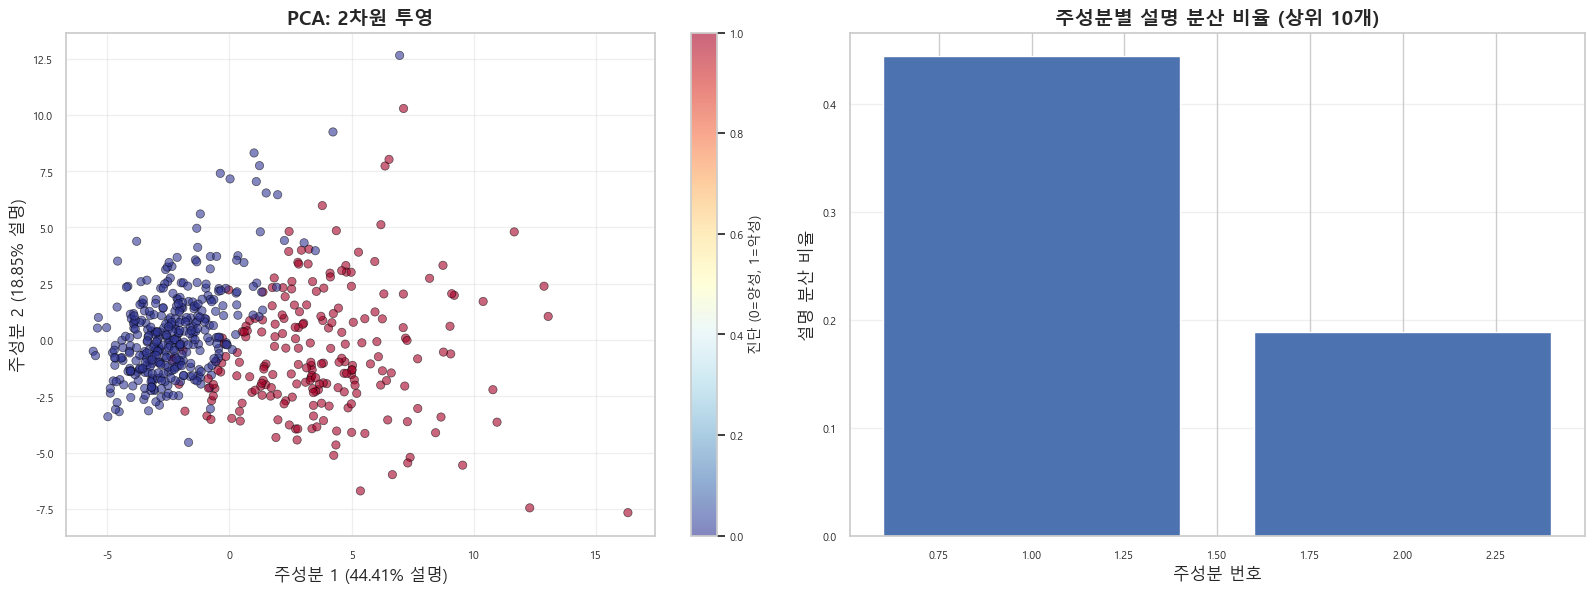

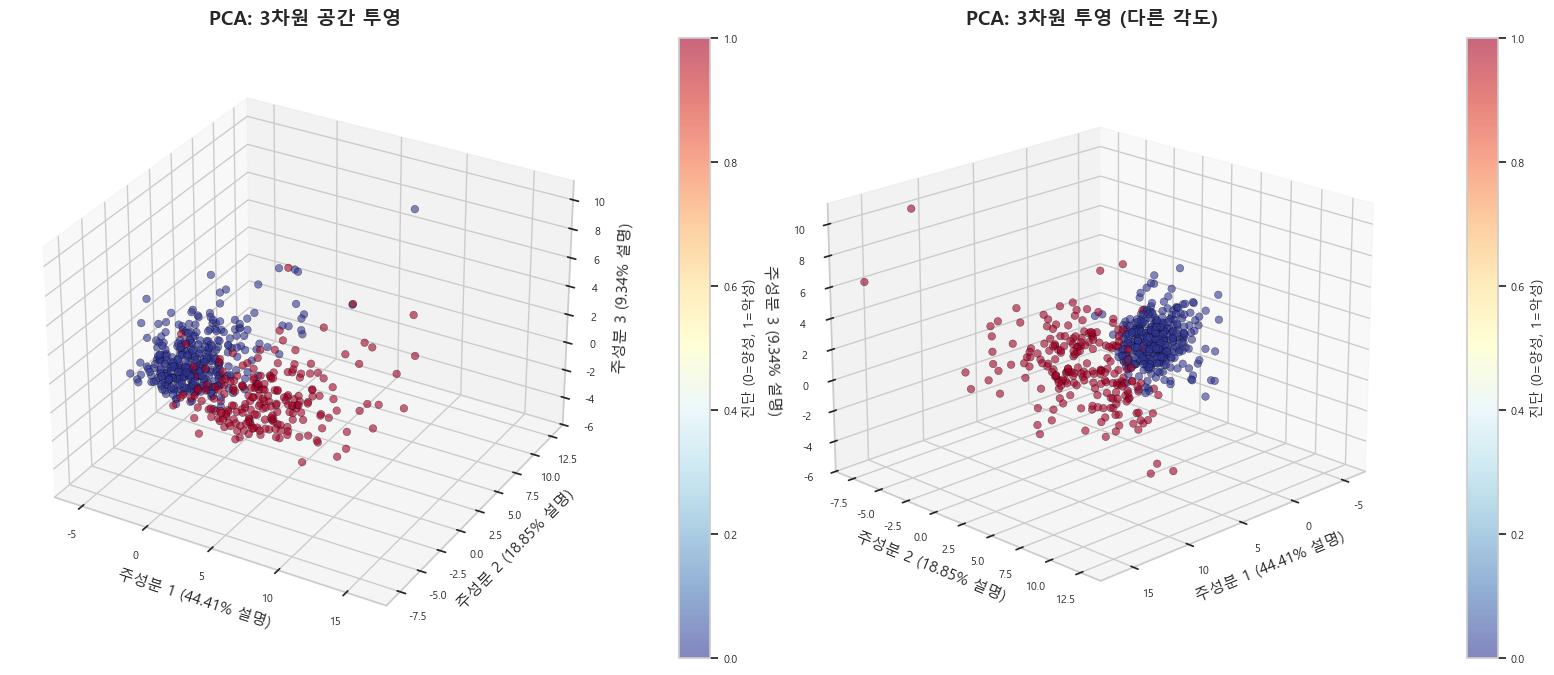


인터랙티브 3D PCA 시각화 생성 중...
노트북 내 표시 중 오류: Mime type rendering requires nbformat>=4.2.0 but it is not installed

✅ 인터랙티브 3D PCA 그래프가 'pca_3d_interactive.html' 파일로 저장되었습니다!
파일 경로: c:\Users\angel\OneDrive\Documents\breast\pca_3d_interactive.html

PCA 완료: 고차원 데이터를 2D/3D로 축소하여 시각화했습니다.


In [16]:
# ============================================
# 시각화 7: PCA (주성분 분석)
# ============================================
print("=" * 50)
print("시각화 7: PCA (주성분 분석)")
print("=" * 50)

# 한글 폰트 재확인 및 적용
import matplotlib.font_manager as fm
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go
import os
from sklearn.decomposition import PCA

font_list = [font.name for font in fm.fontManager.ttflist]
korean_fonts = ['Malgun Gothic', 'NanumGothic', 'NanumBarunGothic', 'AppleGothic', 'Gulim']
selected_font = None
for font in korean_fonts:
    if font in font_list:
        selected_font = font
        break

if selected_font:
    plt.rcParams['font.family'] = selected_font
    plt.rcParams['axes.unicode_minus'] = False

# ==============================
# 1) PCA에 사용할 특징 컬럼 선정
# ==============================
# df_scaled 안에 실제 존재하는 "수치형" 컬럼만 사용
# → diagnosis 같은 범주형/문자형은 자동 제외됨
num_cols_scaled = df_scaled.select_dtypes(include=[np.number]).columns.tolist()
pca_features = num_cols_scaled[:]   # 복사

print("PCA 사용 특징 개수:", len(pca_features))
print("예시 특징:", pca_features[:10])

# PCA 입력 X
X_pca = df_scaled[pca_features].copy()

# ==============================
# 2) y_pca (색깔/라벨용) 만들기
# ==============================
# 1순위: df_scaled에 target 있으면 그거 사용
# 2순위: df에 target 있으면 그거 사용
# 3순위: diagnosis를 B=0, M=1로 매핑해서 사용
if "target" in getattr(df_scaled, "columns", []):
    y_pca = df_scaled["target"].copy().values
    print("y_pca: df_scaled['target'] 사용")
elif "target" in getattr(df, "columns", []):
    y_pca = df["target"].copy().values
    print("y_pca: df['target'] 사용")
else:
    y_pca = df["diagnosis"].map({"B": 0, "M": 1}).values
    print("y_pca: diagnosis를 B=0, M=1로 매핑해서 사용")

# ==============================
# 3) 값 이상 여부 체크
# ==============================
print(f"PCA 데이터 확인: {len(X_pca)}개 샘플, {len(pca_features)}개 특징")
print(f"NaN 값: {X_pca.isnull().sum().sum()}개")
print(f"무한대 값: {np.isinf(X_pca).sum().sum()}개")

if X_pca.isnull().sum().sum() > 0 or np.isinf(X_pca).sum().sum() > 0:
    print("⚠️ 문제가 있는 값이 발견되어 제거합니다.")
    valid_mask = ~(X_pca.isnull().any(axis=1) | np.isinf(X_pca).any(axis=1))
    X_pca = X_pca[valid_mask]
    y_pca = y_pca[valid_mask]
    print(f"정제 후 데이터: {len(X_pca)}개 샘플")

# ==============================
# 4) PCA 수행 (2D, 3D)
# ==============================
pca_2d = PCA(n_components=2, random_state=42)
X_pca_2d = pca_2d.fit_transform(X_pca)

pca_3d = PCA(n_components=3, random_state=42)
X_pca_3d = pca_3d.fit_transform(X_pca)

explained_variance_2d = pca_2d.explained_variance_ratio_
explained_variance_3d = pca_3d.explained_variance_ratio_

print(f"\n2D PCA 설명 분산:")
print(f"  주성분 1: {explained_variance_2d[0]:.2%}")
print(f"  주성분 2: {explained_variance_2d[1]:.2%}")
print(f"  총 설명 분산: {explained_variance_2d.sum():.2%}")

print(f"\n3D PCA 설명 분산:")
print(f"  주성분 1: {explained_variance_3d[0]:.2%}")
print(f"  주성분 2: {explained_variance_3d[1]:.2%}")
print(f"  주성분 3: {explained_variance_3d[2]:.2%}")
print(f"  총 설명 분산: {explained_variance_3d.sum():.2%}")

# ==============================
# 5) 2D PCA 시각화
# ==============================
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

scatter_2d = axes[0].scatter(
    X_pca_2d[:, 0],
    X_pca_2d[:, 1],
    c=y_pca,
    cmap='RdYlBu_r',
    alpha=0.6,
    edgecolors='black',
    linewidth=0.5
)

if selected_font:
    axes[0].set_xlabel(f'주성분 1 ({explained_variance_2d[0]:.2%} 설명)', fontsize=12, fontfamily=selected_font)
    axes[0].set_ylabel(f'주성분 2 ({explained_variance_2d[1]:.2%} 설명)', fontsize=12, fontfamily=selected_font)
    axes[0].set_title('PCA: 2차원 투영', fontsize=14, fontweight='bold', fontfamily=selected_font)
else:
    axes[0].set_xlabel(f'주성분 1 ({explained_variance_2d[0]:.2%} 설명)', fontsize=12)
    axes[0].set_ylabel(f'주성분 2 ({explained_variance_2d[1]:.2%} 설명)', fontsize=12)
    axes[0].set_title('PCA: 2차원 투영', fontsize=14, fontweight='bold')

axes[0].grid(True, alpha=0.3)
cbar1 = plt.colorbar(scatter_2d, ax=axes[0])
label_text = '진단 (0=양성, 1=악성)'
if selected_font:
    cbar1.set_label(label_text, fontsize=10, fontfamily=selected_font)
else:
    cbar1.set_label(label_text, fontsize=10)

# 설명 분산 비율 막대그래프
n_pc = min(10, len(pca_2d.explained_variance_ratio_))
axes[1].bar(range(1, n_pc + 1), pca_2d.explained_variance_ratio_[:n_pc])

if selected_font:
    axes[1].set_xlabel('주성분 번호', fontsize=12, fontfamily=selected_font)
    axes[1].set_ylabel('설명 분산 비율', fontsize=12, fontfamily=selected_font)
    axes[1].set_title('주성분별 설명 분산 비율 (상위 10개)', fontsize=14, fontweight='bold', fontfamily=selected_font)
else:
    axes[1].set_xlabel('주성분 번호', fontsize=12)
    axes[1].set_ylabel('설명 분산 비율', fontsize=12)
    axes[1].set_title('주성분별 설명 분산 비율 (상위 10개)', fontsize=14, fontweight='bold')

axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# ==============================
# 6) 3D PCA 시각화 (matplotlib)
# ==============================
fig = plt.figure(figsize=(16, 8))
ax_3d = fig.add_subplot(121, projection='3d')

scatter_3d = ax_3d.scatter(
    X_pca_3d[:, 0],
    X_pca_3d[:, 1],
    X_pca_3d[:, 2],
    c=y_pca,
    cmap='RdYlBu_r',
    alpha=0.6,
    edgecolors='black',
    linewidth=0.3,
    s=30
)

if selected_font:
    ax_3d.set_xlabel(f'주성분 1 ({explained_variance_3d[0]:.2%} 설명)', fontsize=11, fontfamily=selected_font)
    ax_3d.set_ylabel(f'주성분 2 ({explained_variance_3d[1]:.2%} 설명)', fontsize=11, fontfamily=selected_font)
    ax_3d.set_zlabel(f'주성분 3 ({explained_variance_3d[2]:.2%} 설명)', fontsize=11, fontfamily=selected_font)
    ax_3d.set_title('PCA: 3차원 공간 투영', fontsize=14, fontweight='bold', pad=20, fontfamily=selected_font)
else:
    ax_3d.set_xlabel(f'주성분 1 ({explained_variance_3d[0]:.2%} 설명)', fontsize=11)
    ax_3d.set_ylabel(f'주성분 2 ({explained_variance_3d[1]:.2%} 설명)', fontsize=11)
    ax_3d.set_zlabel(f'주성분 3 ({explained_variance_3d[2]:.2%} 설명)', fontsize=11)
    ax_3d.set_title('PCA: 3차원 공간 투영', fontsize=14, fontweight='bold', pad=20)

cbar_3d = plt.colorbar(scatter_3d, ax=ax_3d, pad=0.1, shrink=0.8)
if selected_font:
    cbar_3d.set_label(label_text, fontsize=10, fontfamily=selected_font)
else:
    cbar_3d.set_label(label_text, fontsize=10)

# 다른 각도의 3D 뷰
ax_3d_view = fig.add_subplot(122, projection='3d')
scatter_3d_view = ax_3d_view.scatter(
    X_pca_3d[:, 0],
    X_pca_3d[:, 1],
    X_pca_3d[:, 2],
    c=y_pca,
    cmap='RdYlBu_r',
    alpha=0.6,
    edgecolors='black',
    linewidth=0.3,
    s=30
)

ax_3d_view.view_init(elev=20, azim=45)

if selected_font:
    ax_3d_view.set_xlabel(f'주성분 1 ({explained_variance_3d[0]:.2%} 설명)', fontsize=11, fontfamily=selected_font)
    ax_3d_view.set_ylabel(f'주성분 2 ({explained_variance_3d[1]:.2%} 설명)', fontsize=11, fontfamily=selected_font)
    ax_3d_view.set_zlabel(f'주성분 3 ({explained_variance_3d[2]:.2%} 설명)', fontsize=11, fontfamily=selected_font)
    ax_3d_view.set_title('PCA: 3차원 투영 (다른 각도)', fontsize=14, fontweight='bold', pad=20, fontfamily=selected_font)
else:
    ax_3d_view.set_xlabel(f'주성분 1 ({explained_variance_3d[0]:.2%} 설명)', fontsize=11)
    ax_3d_view.set_ylabel(f'주성분 2 ({explained_variance_3d[1]:.2%} 설명)', fontsize=11)
    ax_3d_view.set_zlabel(f'주성분 3 ({explained_variance_3d[2]:.2%} 설명)', fontsize=11)
    ax_3d_view.set_title('PCA: 3차원 투영 (다른 각도)', fontsize=14, fontweight='bold', pad=20)

cbar_3d_view = plt.colorbar(scatter_3d_view, ax=ax_3d_view, pad=0.1, shrink=0.8)
if selected_font:
    cbar_3d_view.set_label(label_text, fontsize=10, fontfamily=selected_font)
else:
    cbar_3d_view.set_label(label_text, fontsize=10)

plt.tight_layout()
plt.show()

# ==============================
# 7) Plotly 인터랙티브 3D PCA
# ==============================
print("\n인터랙티브 3D PCA 시각화 생성 중...")

benign_mask = (y_pca == 0)
malignant_mask = (y_pca == 1)

fig_plotly = go.Figure()

fig_plotly.add_trace(go.Scatter3d(
    x=X_pca_3d[benign_mask, 0],
    y=X_pca_3d[benign_mask, 1],
    z=X_pca_3d[benign_mask, 2],
    mode='markers',
    marker=dict(size=5, color='green', opacity=0.7, line=dict(width=0.5, color='darkgreen')),
    name='양성(B)'
))

fig_plotly.add_trace(go.Scatter3d(
    x=X_pca_3d[malignant_mask, 0],
    y=X_pca_3d[malignant_mask, 1],
    z=X_pca_3d[malignant_mask, 2],
    mode='markers',
    marker=dict(size=5, color='red', opacity=0.7, line=dict(width=0.5, color='darkred')),
    name='악성(M)'
))

fig_plotly.update_layout(
    title=dict(
        text='PCA: 3차원 인터랙티브 시각화 (마우스로 드래그/확대/축소 가능)',
        x=0.5,
        font=dict(size=16, family='Arial, sans-serif')
    ),
    scene=dict(
        xaxis_title=f'주성분 1 ({explained_variance_3d[0]:.2%} 설명)',
        yaxis_title=f'주성분 2 ({explained_variance_3d[1]:.2%} 설명)',
        zaxis_title=f'주성분 3 ({explained_variance_3d[2]:.2%} 설명)',
        camera=dict(eye=dict(x=1.5, y=1.5, z=1.5))
    ),
    width=1000,
    height=800
)

try:
    fig_plotly.show()
except Exception as e:
    print("노트북 내 표시 중 오류:", e)

html_filename = 'pca_3d_interactive.html'
fig_plotly.write_html(html_filename)
print(f"\n✅ 인터랙티브 3D PCA 그래프가 '{html_filename}' 파일로 저장되었습니다!")
print(f"파일 경로: {os.path.abspath(html_filename)}")

print("\nPCA 완료: 고차원 데이터를 2D/3D로 축소하여 시각화했습니다.")


시각화 8: t-SNE
t-SNE 사용 특징 개수: 31
예시 특징: ['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean', 'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean']
y_tsne: diagnosis를 B=0, M=1로 매핑해서 사용
t-SNE 계산을 위해 500개 샘플 사용
t-SNE 계산 중... (시간이 걸릴 수 있습니다)
t-SNE 계산 완료!


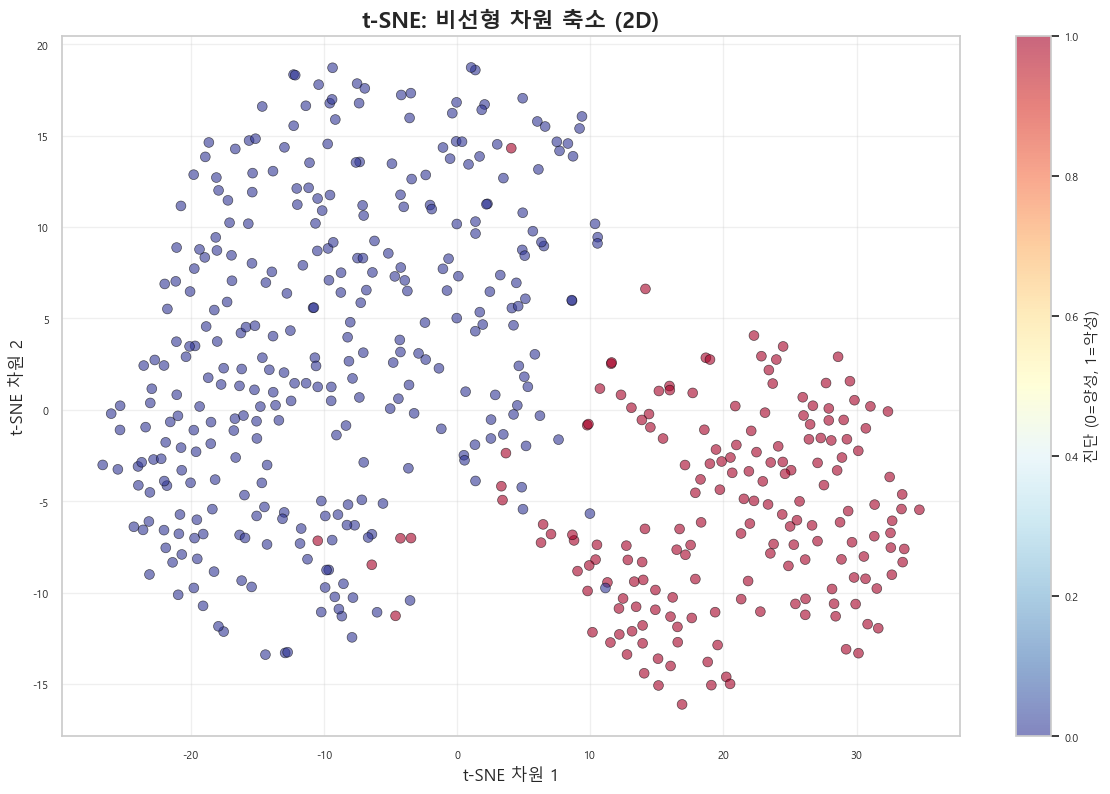

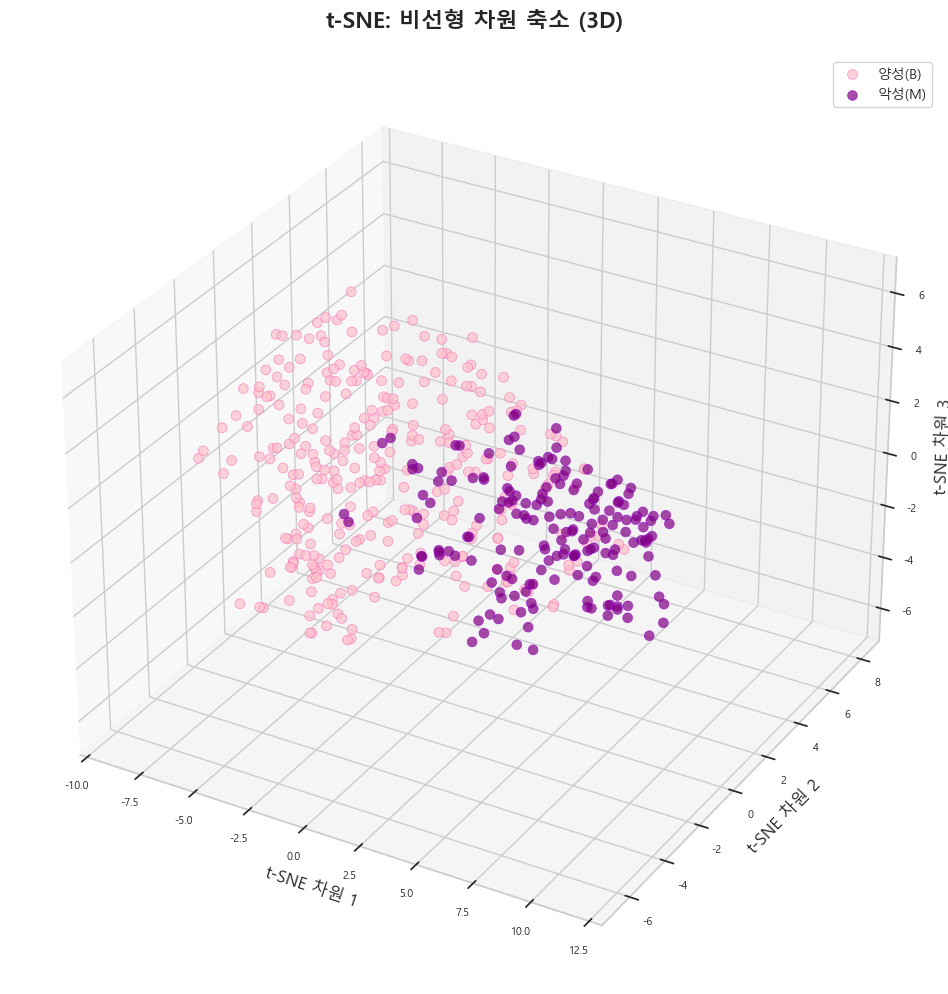


인터랙티브 t-SNE 시각화 생성 중...
노트북 내 표시 중 오류 발생 (HTML 저장은 정상 진행): Mime type rendering requires nbformat>=4.2.0 but it is not installed

✅ 인터랙티브 3D t-SNE 그래프가 'tsne_3d_interactive.html' 파일로 저장되었습니다!
   파일 경로: c:\Users\angel\OneDrive\Documents\breast\tsne_3d_interactive.html

✅ t-SNE 완료: 비선형 구조를 보존한 차원 축소 결과를 2D/3D로 시각화했습니다.


In [17]:
# ============================================
# 시각화 8: t-SNE (t-분포 확률적 이웃 임베딩)
# ============================================
print("=" * 50)
print("시각화 8: t-SNE")
print("=" * 50)

# 한글 폰트 재확인 및 적용
import matplotlib.font_manager as fm
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go
import os
from sklearn.manifold import TSNE

font_list = [font.name for font in fm.fontManager.ttflist]
korean_fonts = ['Malgun Gothic', 'NanumGothic', 'NanumBarunGothic', 'AppleGothic', 'Gulim']
selected_font = None
for font in korean_fonts:
    if font in font_list:
        selected_font = font
        break

if selected_font:
    plt.rcParams['font.family'] = selected_font
    plt.rcParams['axes.unicode_minus'] = False

# ==============================
# 1) t-SNE에 사용할 특징 / 라벨 준비
# ==============================

# df_scaled 안의 "숫자형 컬럼"만 사용 (diagnosis 같은 문자 컬럼 자동 제외)
num_cols_scaled = df_scaled.select_dtypes(include=[np.number]).columns.tolist()

# 혹시 'target'이 숫자형에 포함돼 있으면 피처에서는 제외
tsne_features = [c for c in num_cols_scaled if c != "target"]

print("t-SNE 사용 특징 개수:", len(tsne_features))
print("예시 특징:", tsne_features[:10])

# 전체 X, y 준비
X_all = df_scaled[tsne_features].values

# y는 0/1 숫자로 맞추기
if "target" in getattr(df_scaled, "columns", []):
    y_all = df_scaled["target"].values
    print("y_tsne: df_scaled['target'] 사용")
elif "target" in getattr(df, "columns", []):
    y_all = df["target"].values
    print("y_tsne: df['target'] 사용")
else:
    # 최후 수단: diagnosis를 B=0, M=1로 매핑
    y_all = df["diagnosis"].map({"B": 0, "M": 1}).values
    print("y_tsne: diagnosis를 B=0, M=1로 매핑해서 사용")

# ==============================
# 2) 샘플링 (t-SNE는 계산량 많음)
# ==============================
sample_size = min(500, len(X_all))

if len(X_all) > sample_size:
    sample_idx = np.random.choice(len(X_all), sample_size, replace=False)
    X_tsne = X_all[sample_idx]
    y_tsne = y_all[sample_idx]
    print(f"t-SNE 계산을 위해 {sample_size}개 샘플 사용")
else:
    X_tsne = X_all
    y_tsne = y_all
    print(f"t-SNE 계산: 전체 {len(X_all)}개 샘플 사용")

# ==============================
# 3) t-SNE 수행 (2D, 3D)
# ==============================
print("t-SNE 계산 중... (시간이 걸릴 수 있습니다)")

tsne_2d = TSNE(
    n_components=2,
    random_state=42,
    perplexity=30,
    max_iter=1000
)
X_tsne_2d = tsne_2d.fit_transform(X_tsne)

tsne_3d = TSNE(
    n_components=3,
    random_state=42,
    perplexity=30,
    max_iter=1000
)
X_tsne_3d = tsne_3d.fit_transform(X_tsne)

print("t-SNE 계산 완료!")

# ==============================
# 4) matplotlib 2D 시각화
# ==============================
plt.figure(figsize=(12, 8))
scatter = plt.scatter(
    X_tsne_2d[:, 0],
    X_tsne_2d[:, 1],
    c=y_tsne,
    cmap='RdYlBu_r',
    alpha=0.6,
    edgecolors='black',
    linewidth=0.5,
    s=50
)
plt.xlabel('t-SNE 차원 1', fontsize=12)
plt.ylabel('t-SNE 차원 2', fontsize=12)
plt.title('t-SNE: 비선형 차원 축소 (2D)', fontsize=16, fontweight='bold')
cbar = plt.colorbar(scatter)
cbar.set_label('진단 (0=양성, 1=악성)', fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# ==============================
# 5) matplotlib 3D 시각화 (핑크/보라)
# ==============================
fig_3d = plt.figure(figsize=(14, 10))
ax_3d = fig_3d.add_subplot(111, projection='3d')

benign_mask = (y_tsne == 0)
malignant_mask = (y_tsne == 1)

# 양성(B) — 핑크
ax_3d.scatter(
    X_tsne_3d[benign_mask, 0],
    X_tsne_3d[benign_mask, 1],
    X_tsne_3d[benign_mask, 2],
    c='pink',
    s=50,
    alpha=0.7,
    edgecolors='hotpink',
    linewidth=0.5,
    label='양성(B)'
)

# 악성(M) — 보라
ax_3d.scatter(
    X_tsne_3d[malignant_mask, 0],
    X_tsne_3d[malignant_mask, 1],
    X_tsne_3d[malignant_mask, 2],
    c='purple',
    s=50,
    alpha=0.7,
    edgecolors='darkviolet',
    linewidth=0.5,
    label='악성(M)'
)

ax_3d.set_xlabel('t-SNE 차원 1', fontsize=12)
ax_3d.set_ylabel('t-SNE 차원 2', fontsize=12)
ax_3d.set_zlabel('t-SNE 차원 3', fontsize=12)
ax_3d.set_title('t-SNE: 비선형 차원 축소 (3D)', fontsize=16, fontweight='bold', pad=20)
ax_3d.legend(loc='upper right', fontsize=10)
plt.tight_layout()
plt.show()

# ==============================
# 6) Plotly 인터랙티브 3D 시각화
# ==============================
print("\n인터랙티브 t-SNE 시각화 생성 중...")

fig_tsne_3d = go.Figure()

# 양성(B)
benign_mask_tsne = (y_tsne == 0)
fig_tsne_3d.add_trace(go.Scatter3d(
    x=X_tsne_3d[benign_mask_tsne, 0],
    y=X_tsne_3d[benign_mask_tsne, 1],
    z=X_tsne_3d[benign_mask_tsne, 2],
    mode='markers',
    marker=dict(
        size=6,
        color='pink',
        opacity=0.7,
        line=dict(width=0.5, color='hotpink')
    ),
    name='양성(B)',
    text=[f'샘플 {i}' for i in range(len(X_tsne_3d[benign_mask_tsne]))],
    hovertemplate='<b>양성(B)</b><br>' +
                  't-SNE 차원 1: %{x:.3f}<br>' +
                  't-SNE 차원 2: %{y:.3f}<br>' +
                  't-SNE 차원 3: %{z:.3f}<br>' +
                  '<extra></extra>'
))

# 악성(M)
malignant_mask_tsne = (y_tsne == 1)
fig_tsne_3d.add_trace(go.Scatter3d(
    x=X_tsne_3d[malignant_mask_tsne, 0],
    y=X_tsne_3d[malignant_mask_tsne, 1],
    z=X_tsne_3d[malignant_mask_tsne, 2],
    mode='markers',
    marker=dict(
        size=6,
        color='purple',
        opacity=0.7,
        line=dict(width=0.5, color='darkviolet')
    ),
    name='악성(M)',
    text=[f'샘플 {i}' for i in range(len(X_tsne_3d[malignant_mask_tsne]))],
    hovertemplate='<b>악성(M)</b><br>' +
                  't-SNE 차원 1: %{x:.3f}<br>' +
                  't-SNE 차원 2: %{y:.3f}<br>' +
                  't-SNE 차원 3: %{z:.3f}<br>' +
                  '<extra></extra>'
))

fig_tsne_3d.update_layout(
    title=dict(
        text='t-SNE: 3D 비선형 차원 축소 인터랙티브 시각화 (마우스로 회전/확대)',
        x=0.5,
        font=dict(size=16, family='Arial, sans-serif')
    ),
    scene=dict(
        xaxis_title='t-SNE 차원 1',
        yaxis_title='t-SNE 차원 2',
        zaxis_title='t-SNE 차원 3',
        camera=dict(eye=dict(x=1.5, y=1.5, z=1.5))
    ),
    width=1000,
    height=800,
    hovermode='closest',
    legend=dict(
        x=1.02,
        y=1,
        bgcolor='rgba(255, 255, 255, 0.8)',
        bordercolor='black',
        borderwidth=1
    )
)

# 노트북에서 표시 (에러 발생 시 건너뜀)
try:
    fig_tsne_3d.show()
except Exception as e:
    print(f"노트북 내 표시 중 오류 발생 (HTML 저장은 정상 진행): {str(e)}")

# HTML 파일로 저장
html_filename_tsne_3d = 'tsne_3d_interactive.html'
fig_tsne_3d.write_html(html_filename_tsne_3d)
print(f"\n✅ 인터랙티브 3D t-SNE 그래프가 '{html_filename_tsne_3d}' 파일로 저장되었습니다!")
print(f"   파일 경로: {os.path.abspath(html_filename_tsne_3d)}")

print("\n✅ t-SNE 완료: 비선형 구조를 보존한 차원 축소 결과를 2D/3D로 시각화했습니다.")


In [18]:
# ============================================
# 모델 학습 및 평가
# ============================================
print("=" * 50)
print("모델 학습 및 평가")
print("=" * 50)

# 데이터 분할
X = df_scaled.drop(columns=['diagnosis'])
y = df_scaled['diagnosis']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"훈련 데이터: {X_train.shape[0]}개")
print(f"테스트 데이터: {X_test.shape[0]}개")

# 모델 학습
rf_clf = RandomForestClassifier(random_state=42, n_estimators=300, max_depth=None, n_jobs=-1)
dt_clf = DecisionTreeClassifier(random_state=42, max_depth=5)

print("\n모델 학습 중...")
rf_clf.fit(X_train, y_train)
dt_clf.fit(X_train, y_train)
print("모델 학습 완료!")

# 모델 평가
models = {'Random Forest': rf_clf, 'Decision Tree': dt_clf}

for name, model in models.items():
    y_pred = model.predict(X_test)
    print(f"\n{'='*50}")
    print(f"{name} 성능")
    print(f"{'='*50}")
    print(f"정확도: {accuracy_score(y_test, y_pred):.4f}")
    print(f"\n분류 보고서:")
    print(classification_report(y_test, y_pred, target_names=['양성(B)', '악성(M)']))
    print(f"\n혼동 행렬:")
    print(confusion_matrix(y_test, y_pred))


모델 학습 및 평가
훈련 데이터: 455개
테스트 데이터: 114개

모델 학습 중...
모델 학습 완료!

Random Forest 성능
정확도: 0.9737

분류 보고서:
              precision    recall  f1-score   support

       양성(B)       0.96      1.00      0.98        72
       악성(M)       1.00      0.93      0.96        42

    accuracy                           0.97       114
   macro avg       0.98      0.96      0.97       114
weighted avg       0.97      0.97      0.97       114


혼동 행렬:
[[72  0]
 [ 3 39]]

Decision Tree 성능
정확도: 0.9211

분류 보고서:
              precision    recall  f1-score   support

       양성(B)       0.91      0.97      0.94        72
       악성(M)       0.95      0.83      0.89        42

    accuracy                           0.92       114
   macro avg       0.93      0.90      0.91       114
weighted avg       0.92      0.92      0.92       114


혼동 행렬:
[[70  2]
 [ 7 35]]


XAI 1: SHAP 분석


c:\Users\angel\OneDrive\Documents\breast\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html



기존 rf_clf 모델 사용!
SHAP 분석에 사용할 샘플 개수: 114
SHAP 값 계산 중...
SHAP 값 shape: (114, 30)

SHAP Summary Plot 생성 중...


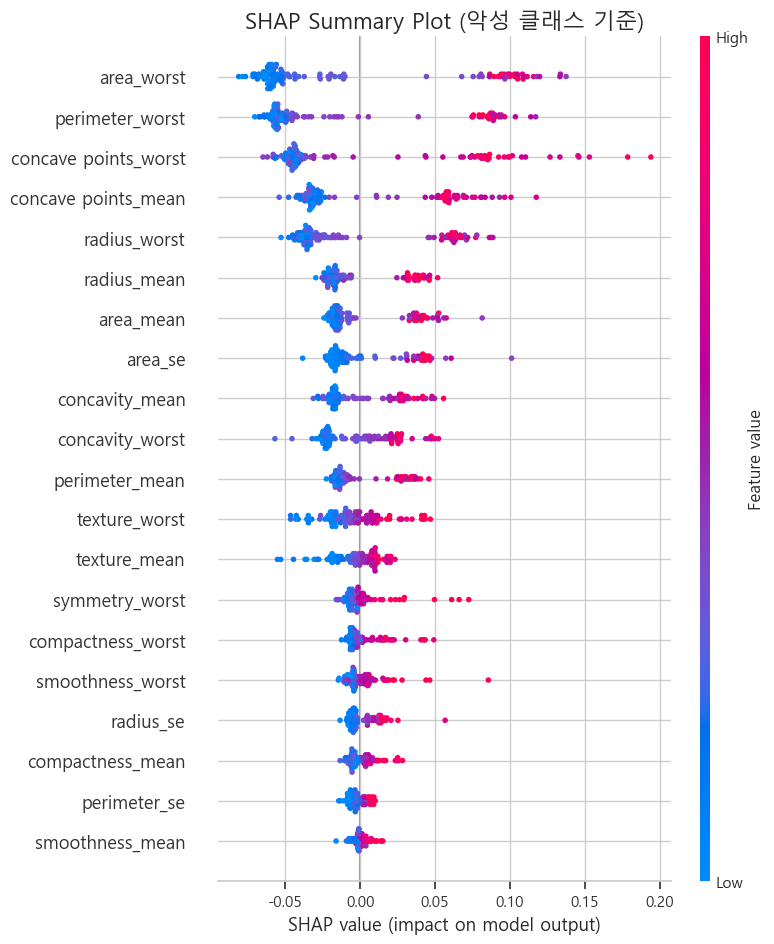


SHAP Bar Plot 생성 중...


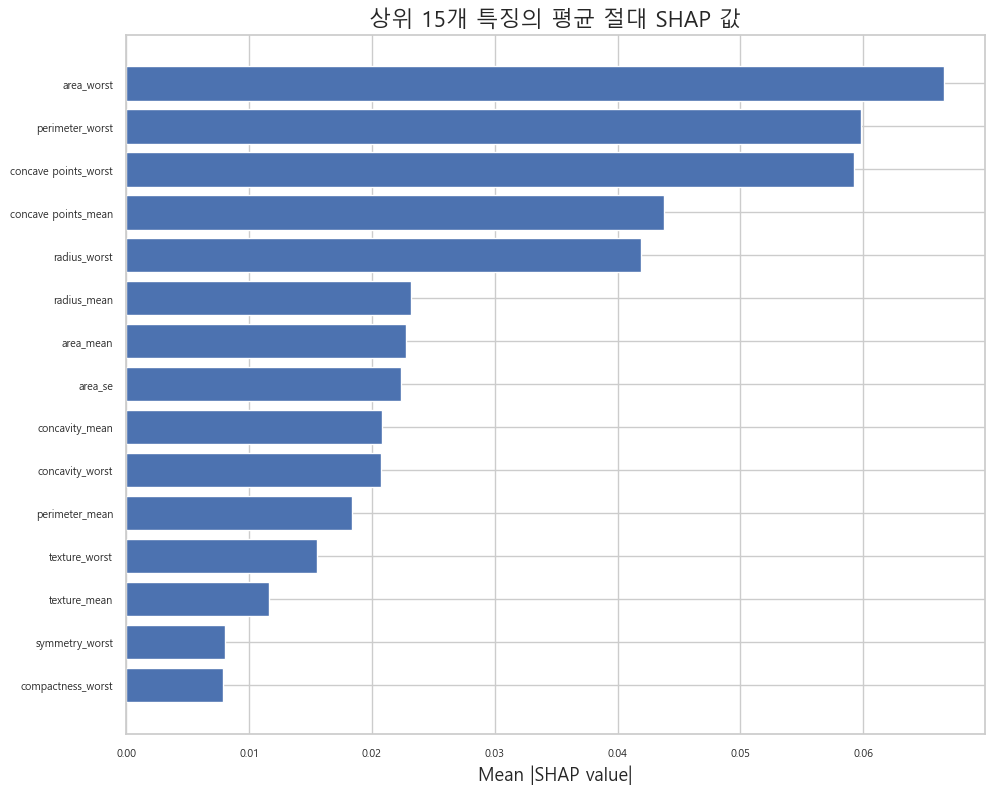

✅ SHAP 분석 완료!


In [19]:
# ============================================
# XAI 1: SHAP (SHapley Additive exPlanations)
# ============================================
print("=" * 50)
print("XAI 1: SHAP 분석")
print("=" * 50)

# 1) SHAP 라이브러리 확인
try:
    import shap
except ImportError:
    print("⚠️ shap 패키지가 설치되어 있지 않습니다.")
    print("   -> 터미널/콘솔에서:  pip install shap")
    raise

# 2) 데이터, 모델 다시 한 번 안전하게 준비
# df_scaled 에서 특징(X), 타깃(y) 분리
X = df_scaled.drop(columns=['diagnosis'])
y = df_scaled['diagnosis']

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# 학습/테스트 데이터 분할 (이미 있다면 그대로 덮어써도 무방)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# RandomForest 모델 (이미 rf_clf가 있으면 재학습 안 해도 됨)
if 'rf_clf' not in globals():
    rf_clf = RandomForestClassifier(
        n_estimators=200,
        max_depth=None,
        random_state=42,
        n_jobs=-1
    )
    rf_clf.fit(X_train, y_train)
    print("RandomForest 새로 학습 완료!")
else:
    print("기존 rf_clf 모델 사용!")

# 3) SHAP용 샘플 추출 (너무 많으면 줄이기)
X_test_sample = X_test.copy()
if len(X_test_sample) > 300:
    X_test_sample = X_test_sample.sample(300, random_state=42)
print(f"SHAP 분석에 사용할 샘플 개수: {len(X_test_sample)}")

# 4) TreeExplainer 생성
explainer = shap.TreeExplainer(rf_clf)

# 5) SHAP 값 계산
print("SHAP 값 계산 중...")
shap_values = explainer.shap_values(X_test_sample)

# 6) 이진분류(breast cancer)에서 악성(1) 클래스 SHAP 값만 뽑기
import numpy as np

if isinstance(shap_values, list):
    # 보통 [클래스0, 클래스1] 리스트로 반환됨
    shap_values_class1 = shap_values[1]
else:
    # 배열인 경우: (n_samples, n_features) 또는 (n_samples, n_features, n_classes) 형태
    if shap_values.ndim == 3:
        # (샘플, 특성, 클래스)
        shap_values_class1 = shap_values[:, :, 1]
    else:
        shap_values_class1 = shap_values

print("SHAP 값 shape:", np.array(shap_values_class1).shape)

# 7) 요약 플롯 (Summary Plot)
print("\nSHAP Summary Plot 생성 중...")
shap.initjs()  # JS 기반 시각화 (노트북에서)
plt.figure(figsize=(12, 8))
shap.summary_plot(
    shap_values_class1,
    X_test_sample,
    feature_names=X.columns.tolist(),
    show=False
)
plt.title("SHAP Summary Plot (악성 클래스 기준)", fontsize=16)
plt.tight_layout()
plt.show()

# 8) 바 플롯 (평균 절대 SHAP 값 기준 상위 특징)
print("\nSHAP Bar Plot 생성 중...")
mean_shap = np.abs(shap_values_class1).mean(axis=0)
top_indices = np.argsort(mean_shap)[::-1][:15]

plt.figure(figsize=(10, 8))
plt.barh(
    np.array(X.columns)[top_indices][::-1],
    mean_shap[top_indices][::-1]
)
plt.xlabel("Mean |SHAP value|", fontsize=13)
plt.title("상위 15개 특징의 평균 절대 SHAP 값", fontsize=16)
plt.tight_layout()
plt.show()

print("✅ SHAP 분석 완료!")


XAI 2: Permutation Importance
기존 rf_clf 사용!
Permutation Importance 계산 중...


feature  importance_mean  importance_std
21         texture_worst         0.022368        0.005868
27  concave points_worst         0.020614        0.008448
23            area_worst         0.019737        0.011728
26       concavity_worst         0.014474        0.007482
22       perimeter_worst         0.012281        0.008946
1           texture_mean         0.010965        0.008264
7    concave points_mean         0.009649        0.006140
20          radius_worst         0.007895        0.007287
13               area_se         0.005702        0.004184
24      smoothness_worst         0.005263        0.005115
6         concavity_mean         0.005263        0.004297
10             radius_se         0.004825        0.004364
2         perimeter_mean         0.003947        0.004364
0            radius_mean         0.003947        0.004364
3              area_mean         0.003070        0.004184

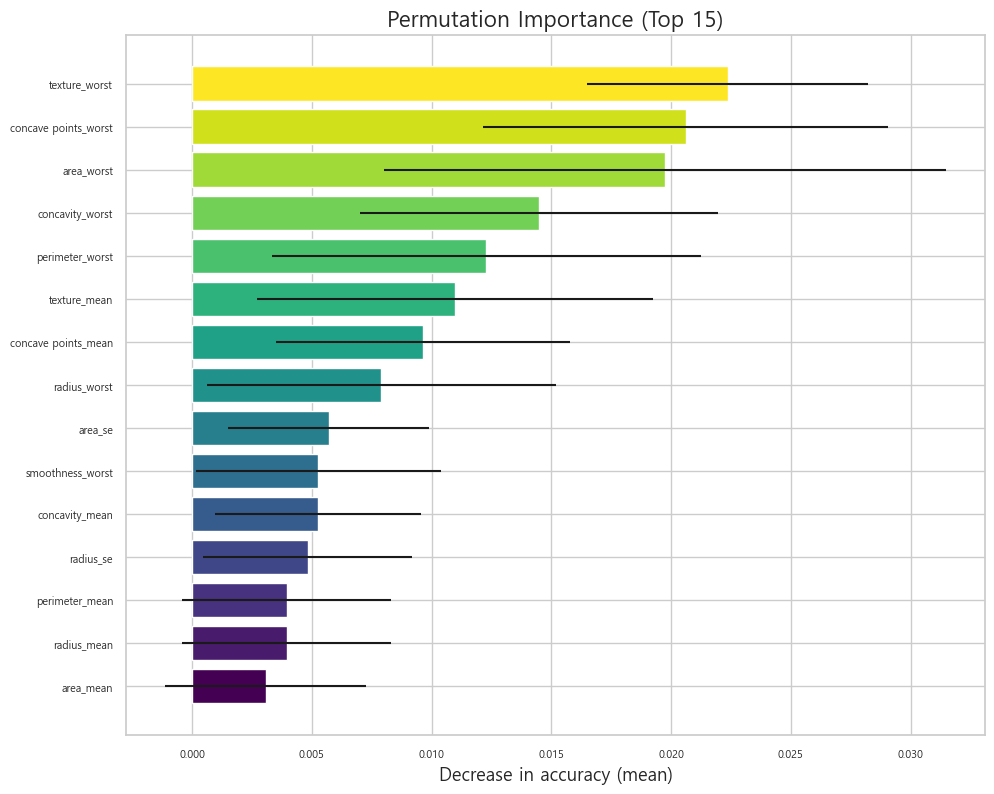

✅ Permutation Importance 완료!


In [21]:
# ============================================
# XAI 2: Permutation Importance
# ============================================
print("=" * 50)
print("XAI 2: Permutation Importance")
print("=" * 50)

from sklearn.inspection import permutation_importance

# 다시 한 번 X, y, train/test 준비 (위 셀과 동일하면 이 부분은 생략 가능)
X = df_scaled.drop(columns=['diagnosis'])
y = df_scaled['diagnosis']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

if 'rf_clf' not in globals():
    from sklearn.ensemble import RandomForestClassifier
    rf_clf = RandomForestClassifier(
        n_estimators=200,
        random_state=42,
        n_jobs=-1
    )
    rf_clf.fit(X_train, y_train)
    print("RandomForest 새로 학습 완료!")
else:
    print("기존 rf_clf 사용!")

# Permutation Importance 계산
print("Permutation Importance 계산 중...")
result = permutation_importance(
    rf_clf,
    X_test,
    y_test,
    n_repeats=20,
    random_state=42,
    n_jobs=-1
)

importances_mean = result.importances_mean
importances_std = result.importances_std

importance_df = pd.DataFrame({
    "feature": X.columns,
    "importance_mean": importances_mean,
    "importance_std": importances_std
}).sort_values("importance_mean", ascending=False)

display(importance_df.head(15))

# 시각화 (상위 15개 특징)
top_k = 15
top_imp = importance_df.head(top_k).iloc[::-1]  # 역순(아래->위)으로 그리기

# 컬러맵 생성 (칼라풀한 색상)
import matplotlib.cm as cm
colors = cm.viridis(np.linspace(0, 1, len(top_imp)))

plt.figure(figsize=(10, 8))
plt.barh(top_imp["feature"], top_imp["importance_mean"],
         xerr=top_imp["importance_std"], color=colors)
plt.xlabel("Decrease in accuracy (mean)", fontsize=13)
plt.title(f"Permutation Importance (Top {top_k})", fontsize=16)
plt.tight_layout()
plt.show()

print("✅ Permutation Importance 완료!")


XAI 3: Partial Dependence / ICE Plot
기존 rf_clf 사용!
Partial Dependence를 그릴 특징: ['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'compactness_mean']
- radius_mean에 대한 Partial Dependence 계산 중...
- texture_mean에 대한 Partial Dependence 계산 중...
- perimeter_mean에 대한 Partial Dependence 계산 중...
- area_mean에 대한 Partial Dependence 계산 중...
- compactness_mean에 대한 Partial Dependence 계산 중...


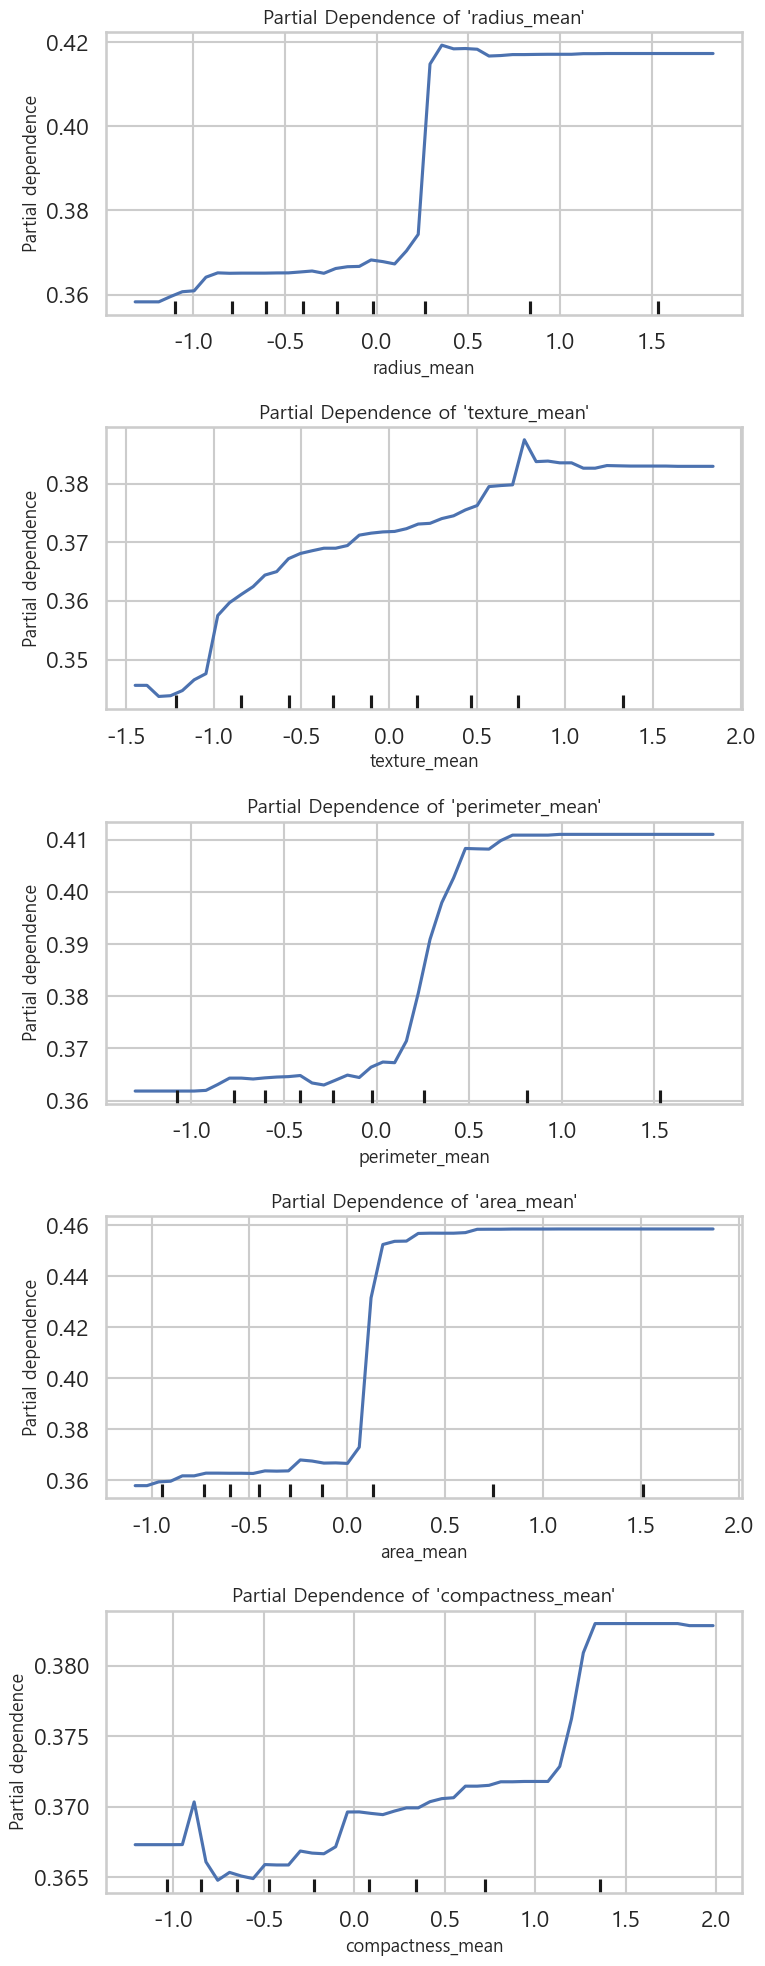

✅ Partial Dependence Plot 완료!


In [30]:
# ============================================
# XAI 3: Partial Dependence Plot & ICE
# ============================================
print("=" * 50)
print("XAI 3: Partial Dependence / ICE Plot")
print("=" * 50)

from sklearn.inspection import PartialDependenceDisplay

# 다시 한 번 X, y, train/test
X = df_scaled.drop(columns=['diagnosis'])
y = df_scaled['diagnosis']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

if 'rf_clf' not in globals():
    from sklearn.ensemble import RandomForestClassifier
    rf_clf = RandomForestClassifier(
        n_estimators=200,
        random_state=42,
        n_jobs=-1
    )
    rf_clf.fit(X_train, y_train)
    print("RandomForest 새로 학습 완료!")
else:
    print("기존 rf_clf 사용!")

# 부분 의존도(Partial Dependence)를 보고 싶은 특징 선택
target_features = [
    'radius_mean',
    'texture_mean',
    'perimeter_mean',
    'area_mean',
    'compactness_mean'
]
target_features = [f for f in target_features if f in X.columns]

print("Partial Dependence를 그릴 특징:", target_features)

if len(target_features) == 0:
    print("⚠️ 지정한 특징 이름이 데이터에 없습니다.")
else:
    fig, ax = plt.subplots(
        nrows=len(target_features),
        ncols=1,
        figsize=(8, 4 * len(target_features))
    )

    if len(target_features) == 1:
        ax = [ax]  # 인덱싱 편하게

    for i, feat in enumerate(target_features):
        print(f"- {feat}에 대한 Partial Dependence 계산 중...")
        PartialDependenceDisplay.from_estimator(
            rf_clf,
            X,
            [feat],
            ax=ax[i],
            kind='average',   # 평균 효과
            grid_resolution=50
        )
        ax[i].set_title(f"Partial Dependence of '{feat}'", fontsize=14)

    plt.tight_layout()
    plt.show()

print("✅ Partial Dependence Plot 완료!")


XAI 4: LIME 분석
기존 rf_clf 사용!

샘플 인덱스: 0
실제 진단(y_true): 0 -> 양성(B)
예측 레이블(y_pred): 0 -> 양성(B)
예측 확률 [Benign, Malignant]: [0.98666667 0.01333333]


c:\Users\angel\OneDrive\Documents\breast\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\angel\OneDrive\Documents\breast\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\angel\OneDrive\Documents\breast\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(



LIME에서 사용할 클래스 레이블(label): 0


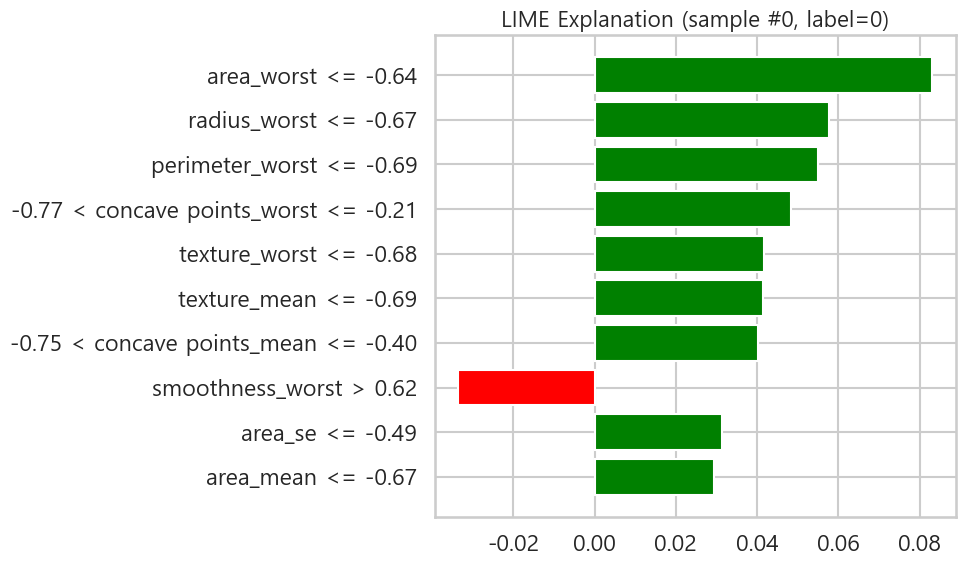

✅ LIME 분석 완료!


In [31]:
# ============================================
# XAI 4: LIME (Local Interpretable Model-agnostic Explanations)
# ============================================
print("=" * 50)
print("XAI 4: LIME 분석")
print("=" * 50)

# 1) LIME 패키지 확인
try:
    from lime.lime_tabular import LimeTabularExplainer
except ImportError:
    print("⚠️ lime 패키지가 설치되어 있지 않습니다.")
    print("   -> 터미널/콘솔에서:  pip install lime")
    raise

# 2) 다시 X, y, train/test
X = df_scaled.drop(columns=['diagnosis'])
y = df_scaled['diagnosis']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

if 'rf_clf' not in globals():
    from sklearn.ensemble import RandomForestClassifier
    rf_clf = RandomForestClassifier(
        n_estimators=200,
        random_state=42,
        n_jobs=-1
    )
    rf_clf.fit(X_train, y_train)
    print("RandomForest 새로 학습 완료!")
else:
    print("기존 rf_clf 사용!")

# 3) LIME 설명자 생성
class_names = ['Benign(0)', 'Malignant(1)']

lime_explainer = LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=X.columns.tolist(),
    class_names=class_names,
    mode='classification',
    discretize_continuous=True
)

# 4) 설명할 샘플 선택
sample_idx = 0  # 원하는 인덱스로 바꿔도 됨
x_sample = X_test.iloc[sample_idx].values.reshape(1, -1)
y_true = y_test.iloc[sample_idx]
y_pred = rf_clf.predict(x_sample)[0]
y_proba = rf_clf.predict_proba(x_sample)[0]

print(f"\n샘플 인덱스: {sample_idx}")
print(f"실제 진단(y_true): {y_true} -> {'악성(M)' if y_true == 1 else '양성(B)'}")
print(f"예측 레이블(y_pred): {y_pred} -> {'악성(M)' if y_pred == 1 else '양성(B)'}")
print(f"예측 확률 [Benign, Malignant]: {y_proba}")

# 5) LIME 설명 계산
lime_exp = lime_explainer.explain_instance(
    data_row=X_test.iloc[sample_idx].values,
    predict_fn=rf_clf.predict_proba,
    num_features=10,
    top_labels=2
)

# LIME가 실제 사용한 레이블 중에서, 모델 예측 레이블과 가장 잘 맞는 것을 선택
available_labels = lime_exp.available_labels()
label_to_plot = int(y_pred) if int(y_pred) in available_labels else available_labels[0]

print(f"\nLIME에서 사용할 클래스 레이블(label): {label_to_plot}")

# 6) 시각화 (matplotlib)
fig = lime_exp.as_pyplot_figure(label=label_to_plot)
plt.title(f"LIME Explanation (sample #{sample_idx}, label={label_to_plot})")
plt.tight_layout()
plt.show()

print("✅ LIME 분석 완료!")


In [ ]:
# ============================================
# XAI 5: ICE (Individual Conditional Expectation) Curves
# ============================================
print("=" * 50)
print("XAI 5: ICE Curves")
print("=" * 50)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib import colormaps  # get_cmap 대체
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import PartialDependenceDisplay

# --------------------------------------------
# 0. df_scaled, diagnosis 존재 여부 확인
# --------------------------------------------
if 'df_scaled' not in globals():
    raise RuntimeError("df_scaled 데이터프레임이 정의되어 있지 않습니다. 앞에서 전처리 셀을 먼저 실행해 주세요.")

if 'diagnosis' not in df_scaled.columns:
    raise RuntimeError("df_scaled 안에 'diagnosis' 컬럼이 없습니다. 타깃 컬럼 이름을 확인해 주세요.")

# --------------------------------------------
# 1. 한글 폰트 재확인 및 적용
# --------------------------------------------
font_list = [font.name for font in fm.fontManager.ttflist]
korean_fonts = ['Malgun Gothic', 'NanumGothic', 'NanumBarunGothic', 'AppleGothic', 'Gulim']
selected_font = None
for font in korean_fonts:
    if font in font_list:
        selected_font = font
        break

if selected_font:
    plt.rcParams['font.family'] = selected_font
    plt.rcParams['axes.unicode_minus'] = False

# --------------------------------------------
# 2. X, y 구성 + NaN/inf 처리 (행 버리지 않고 보간)
# --------------------------------------------

# 2-1) X: diagnosis(문자)만 제외하고 나머지 수치형/스케일된 컬럼 사용
X = df_scaled.drop(columns=['diagnosis'], errors="ignore").copy()

# 2-2) y: target(0/1)가 있으면 사용, 없으면 diagnosis 처리
if "target" in df_scaled.columns:
    y_label = df_scaled["target"].copy()
    print("y_label: df_scaled['target'] 사용")
elif "diagnosis" in df_scaled.columns:
    # diagnosis가 이미 숫자형(0/1)인지 확인
    if df_scaled["diagnosis"].dtype in [np.int64, np.float64, int, float]:
        # 이미 숫자형이면 그대로 사용
        y_label = df_scaled["diagnosis"].copy()
        print("y_label: df_scaled['diagnosis'] (이미 숫자형) 사용")
    else:
        # 문자열이면 매핑
        y_label = df_scaled["diagnosis"].map({"B": 0, "M": 1, "양성(B)": 0, "악성(M)": 1})
        print("y_label: diagnosis를 B=0, M=1로 매핑해서 사용")
else:
    raise RuntimeError("df_scaled에 'target' 또는 'diagnosis' 컬럼이 없습니다.")

# 2-3) y NaN 있는 행은 버림 (진짜 타깃이 없는 행은 쓸 수 없으니까)
mask_y_valid = ~y_label.isna()
X = X.loc[mask_y_valid].copy()
y_label = y_label.loc[mask_y_valid].copy()

print(f"y NaN 제거 후 샘플 수: {len(X)}")

if len(X) == 0:
    raise RuntimeError("타깃 y가 NaN이 아닌 샘플이 없습니다. 원본 데이터의 'diagnosis'를 확인해 주세요.")

# 2-4) X 안의 inf → NaN으로 바꾼 뒤, 각 컬럼별 중앙값으로 채우기
X = X.replace([np.inf, -np.inf], np.nan)

# 중앙값 계산 (전부 NaN인 컬럼은 중앙값도 NaN이지만 Breast Cancer 데이터에선 거의 없을 것)
median_values = X.median(numeric_only=True)

# NaN을 중앙값으로 채우기
X = X.fillna(median_values)

# 그래도 혹시 남아있으면, 그때만 행 드랍 (극단 상황 대비)
mask_X_valid = ~X.isna().any(axis=1)
X_clean = X.loc[mask_X_valid].copy()
y_clean = y_label.loc[mask_X_valid].copy()

print(f"NaN/inf 처리 후 샘플 수: {len(X_clean)}")

if len(X_clean) == 0:
    raise RuntimeError("NaN/inf 처리 후 남은 샘플이 없습니다. df_scaled 전처리를 다시 확인해 주세요.")

# --------------------------------------------
# 3. train/test 분할 + 모델 준비
# --------------------------------------------
# stratify를 쓰려면 클래스가 최소 2개 있어야 함
if y_clean.nunique() < 2:
    raise RuntimeError("y가 하나의 클래스만 포함하고 있습니다. ICE를 그리려면 양성/악성 두 클래스가 모두 필요합니다.")

X_train, X_test, y_train, y_test = train_test_split(
    X_clean, y_clean,
    test_size=0.2,
    random_state=42,
    stratify=y_clean
)

# rf_clf 가 이미 있으면 재사용, 없으면 새로 학습
if 'rf_clf' not in globals():
    rf_clf = RandomForestClassifier(
        n_estimators=200,
        max_depth=None,
        random_state=42,
        n_jobs=-1
    )
    rf_clf.fit(X_train, y_train)
    print("✅ RandomForest 새로 학습 완료 후 ICE 계산 진행")
else:
    print("✅ 기존 rf_clf 모델 사용하여 ICE 계산 진행")

# --------------------------------------------
# 4. ICE에 사용할 feature 설정
# --------------------------------------------
default_feature_name = 'compactness_mean'

if default_feature_name in X_test.columns:
    feature_name = default_feature_name
else:
    numeric_cols = X_test.select_dtypes(include=[np.number]).columns.tolist()
    if len(numeric_cols) == 0:
        raise RuntimeError("수치형 특징이 없습니다. ICE 곡선을 그릴 특징이 필요합니다.")
    feature_name = numeric_cols[0]
    print(f"⚠️ '{default_feature_name}' 컬럼을 찾을 수 없어 '{feature_name}' 컬럼으로 ICE를 그립니다.")

feature_idx = X_test.columns.get_loc(feature_name)

# --------------------------------------------
# 5. ICE 곡선 샘플 선택 & 계산
# --------------------------------------------
try:
    sample_size = min(50, len(X_test))
    if sample_size == 0:
        raise RuntimeError("X_test가 비어있어 ICE 곡선을 계산할 수 없습니다.")
    
    # X_test 인덱스로 샘플 선택 (DataFrame 유지)
    sample_indices = np.random.choice(X_test.index, sample_size, replace=False)
    X_test_ice = X_test.loc[sample_indices].copy()
    
    print(f"ICE 곡선 계산 중... (샘플 {sample_size}개 사용, 특징: {feature_name})")
    
    fig, ax = plt.subplots(figsize=(16, 8))
    
    # 최신 Matplotlib 방식: colormaps.get_cmap 사용
    rainbow = colormaps.get_cmap('hsv')
    # 샘플 수에 맞게 0~1 범위에서 균등하게 색상 생성
    color_values = np.linspace(0, 1, sample_size)
    colors = [rainbow(val) for val in color_values]
    
    # 특징 값 범위 설정
    feature_values = np.linspace(
        X_test[feature_name].min(),
        X_test[feature_name].max(),
        50
    )
    
    # 개별 ICE 곡선 (각 샘플별)
    for idx, (row_idx, base_row) in enumerate(X_test_ice.iterrows()):
        base_df = base_row.to_frame().T  # (1, n_features)
        ice_values = []
        
        for fv in feature_values:
            row_df = base_df.copy()
            row_df[feature_name] = fv
            proba = rf_clf.predict_proba(row_df)[0, 1]  # class=1(악성) 확률
            ice_values.append(proba)
        
        ax.plot(
            feature_values,
            ice_values,
            color=colors[idx],
            alpha=0.6,
            linewidth=1.3
            # label 없음 → 레전드에는 PDP만 표시
        )
    
    # ----------------------------------------
    # 6. 평균 PDP 곡선 (검은 점선)
    # ----------------------------------------
    PartialDependenceDisplay.from_estimator(
        rf_clf,
        X_test,
        features=[feature_name],
        kind='average',
        ax=ax,
        line_kw={
            'color': 'black',
            'linewidth': 3,
            'linestyle': '--',
            'label': '평균 PDP'
        }
    )
    
    # ----------------------------------------
    # 7. 레이블 / 제목 / 레전드
    # ----------------------------------------
    title_text = f'ICE Curves: {feature_name}에 대한 개별 반응 (무지개 색상)'
    
    if selected_font:
        ax.set_xlabel(f'{feature_name}', fontsize=14, fontweight='bold', fontfamily=selected_font)
        ax.set_ylabel('악성 확률', fontsize=14, fontweight='bold', fontfamily=selected_font)
        ax.set_title(title_text, fontsize=18, fontweight='bold', pad=25, fontfamily=selected_font)
    else:
        ax.set_xlabel(f'{feature_name}', fontsize=14, fontweight='bold')
        ax.set_ylabel('악성 확률', fontsize=14, fontweight='bold')
        ax.set_title(title_text, fontsize=18, fontweight='bold', pad=25)
    
    ax.grid(True, alpha=0.3, linestyle='--')
    ax.tick_params(axis='both', which='major', labelsize=11)
    
    handles, labels = ax.get_legend_handles_labels()
    if handles:
        ax.legend(handles, labels, fontsize=12, loc='best')
    
    plt.tight_layout()
    plt.show()
    
    print("✅ ICE Curves 완료!")
    
except Exception as exc:
    print(f"❌ ICE 곡선 계산 중 오류 발생: {exc}")
    import traceback
    traceback.print_exc()
    plt.close()


XAI 5: ICE Curves
y_label: df_scaled['diagnosis'] (이미 숫자형) 사용
y NaN 제거 후 샘플 수: 569
NaN/inf 처리 후 샘플 수: 569
✅ 기존 rf_clf 모델 사용하여 ICE 계산 진행
ICE 곡선 계산 중... (샘플 50개 사용, 특징: compactness_mean)
❌ ICE 곡선 계산 중 오류 발생: ColormapRegistry.get_cmap() takes 2 positional arguments but 3 were given


Traceback (most recent call last):
  File "C:\Users\angel\AppData\Local\Temp\ipykernel_92580\1124501558.py", line 154, in <module>
    rainbow = colormaps.get_cmap('hsv', sample_size)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: ColormapRegistry.get_cmap() takes 2 positional arguments but 3 were given


In [33]:
# ============================================
# 의사결정나무 시각화
# ============================================
print("=" * 50)
print("의사결정나무 구조 시각화")
print("=" * 50)

# 한글 폰트 재확인 및 적용
import matplotlib.font_manager as fm
font_list = [font.name for font in fm.fontManager.ttflist]
korean_fonts = ['Malgun Gothic', 'NanumGothic', 'NanumBarunGothic', 'AppleGothic', 'Gulim']
selected_font = None
for font in korean_fonts:
    if font in font_list:
        selected_font = font
        break

if selected_font:
    plt.rcParams['font.family'] = selected_font
    plt.rcParams['axes.unicode_minus'] = False

plt.figure(figsize=(18, 10))
plot_tree(
    dt_clf, 
    feature_names=X.columns, 
    class_names=['양성(B)', '악성(M)'], 
    filled=True, 
    rounded=True, 
    max_depth=2,  # 깊이 2까지만 표시
    fontsize=11,
    precision=2
)

if selected_font:
    plt.title('의사결정나무 구조 (깊이 2까지 표시)', 
              fontsize=18, fontweight='bold', pad=25, fontfamily=selected_font)
else:
    plt.title('의사결정나무 구조 (깊이 2까지 표시)', 
              fontsize=18, fontweight='bold', pad=25)

plt.tight_layout()
plt.show()

print("의사결정나무 시각화 완료!")


의사결정나무 구조 시각화


NameError: name 'plot_tree' is not defined

<Figure size 1800x1000 with 0 Axes>